In [1]:
import keras
from keras.models import load_model, model_from_json

Using TensorFlow backend.


In [2]:
import tensorflow as tf

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tf.contrib.distributions.Multinomial(total_count=counts_per_example,
                                                logits=logits)
    return -tf.reduce_sum(dist.log_prob(true_counts)) / tf.to_float(tf.shape(true_counts)[0])


class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

from keras.utils import CustomObjectScope
from keras.models import load_model
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
    keras_model = load_model("model.h5")

W0716 12:13:41.403777 139651838932800 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 12:13:41.436225 139651838932800 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0716 12:13:42.148169 139651838932800 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0716 12:13:42.149373 139651838932800 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:184: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto i

In [3]:
keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq (InputLayer)                (None, 1000, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1000, 64)     6464        seq[0][0]                        
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1000, 64)     12352       conv1d_1[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, 1000, 64)     0           conv1d_1[0][0]                   
                                                                 conv1d_2[0][0]                   
__________

In [4]:
def get_out_tensor(inp_tensor, layer_to_copy, param_overrides={}):
    new_config = dict(layer_to_copy.get_config().items())
    for param_name in param_overrides:
        assert param_name in new_config
        new_config[param_name] = param_overrides[param_name]
    new_layer = layer_to_copy.__class__.from_config(new_config)
    adjusted_input_shape = list(layer_to_copy.input_shape)
    assert len(adjusted_input_shape)==3
    adjusted_input_shape[1] = None #flexible input len for convs
    adjusted_input_shape = tuple(adjusted_input_shape)
    new_layer.build(adjusted_input_shape)
    new_layer.set_weights(layer_to_copy.get_weights())
    out_tensor = new_layer(inp_tensor)
    return out_tensor

In [5]:
inp_tensor = keras.layers.Input((None,4))

conv1_out = get_out_tensor(inp_tensor=inp_tensor,
                           layer_to_copy=keras_model.layers[1],
                           param_overrides={'padding': 'same'})
conv2_out = get_out_tensor(inp_tensor=conv1_out,
                           layer_to_copy=keras_model.layers[2],
                           param_overrides={'padding': 'same'})
add_out = keras.layers.Add()([conv1_out, conv2_out])

convs = [conv1_out, conv2_out]

for i in range(8):
    conv_out = get_out_tensor(inp_tensor=add_out,
                              layer_to_copy=keras_model.layers[4 + 2*i],
                              param_overrides={'padding': 'same'})
    convs.append(conv_out)
    add_out = keras.layers.Add()([add_out, conv_out])

gaps = [keras.layers.GlobalAveragePooling1D()(x) for x in convs]

#conv3_out =  get_out_tensor(inp_tensor=add1_out,
#                            layer_to_copy=keras_model.layers[4],
#                            param_overrides={'padding': 'same'})
#add2_out = keras.layers.Add()([add1_out, conv3_out])
#conv4_out =  get_out_tensor(inp_tensor=add2_out,
#                            layer_to_copy=keras_model.layers[6],
#                            param_overrides={'padding': 'same'})
#add3_out = keras.layers.Add()([add2_out, conv4_out])
#conv5_out =  get_out_tensor(inp_tensor=add3_out,
#                            layer_to_copy=keras_model.layers[8],
#                            param_overrides={'padding': 'same'})

#conv1_gap = keras.layers.GlobalAveragePooling1D()(conv1_out)
#conv2_gap = keras.layers.GlobalAveragePooling1D()(conv2_out)
#conv3_gap = keras.layers.GlobalAveragePooling1D()(conv3_out)
#conv4_gap = keras.layers.GlobalAveragePooling1D()(conv4_out)

concat = keras.layers.Concatenate(axis=-1)(gaps)
embedding_model = keras.models.Model(inputs=inp_tensor, outputs=concat)

In [6]:
embedding_model.save("embedding_model.h5")

In [7]:
import numpy as np
embedding_model.predict(np.random.random((10, 41, 4))).shape

(10, 640)

In [8]:
embedding_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     6464        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 64)     12352       conv1d_1[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, None, 64)     0           conv1d_1[0][0]                   
                                                                 conv1d_2[0][0]                   
__________

In [22]:
inp_tensor = keras.layers.Input((None,4))

conv1_out = get_out_tensor(inp_tensor=inp_tensor,
                           layer_to_copy=keras_model.layers[1],
                           param_overrides={'padding': 'same'})
conv2_out = get_out_tensor(inp_tensor=conv1_out,
                           layer_to_copy=keras_model.layers[2],
                           param_overrides={'padding': 'same'})
add_out = keras.layers.Add()([conv1_out, conv2_out])

convs = [conv1_out, conv2_out]

for i in range(8):
    conv_out = get_out_tensor(inp_tensor=add_out,
                              layer_to_copy=keras_model.layers[4 + 2*i],
                              param_overrides={'padding': 'same'})
    convs.append(conv_out)
    add_out = keras.layers.Add()([add_out, conv_out])

#conv3_out =  get_out_tensor(inp_tensor=add1_out,
#                            layer_to_copy=keras_model.layers[4],
#                            param_overrides={'padding': 'same'})
#add2_out = keras.layers.Add()([add1_out, conv3_out])
#conv4_out =  get_out_tensor(inp_tensor=add2_out,
#                            layer_to_copy=keras_model.layers[6],
#                            param_overrides={'padding': 'same'})
#add3_out = keras.layers.Add()([add2_out, conv4_out])
#conv5_out =  get_out_tensor(inp_tensor=add3_out,
#                            layer_to_copy=keras_model.layers[8],
#                            param_overrides={'padding': 'same'})

#conv1_gap = keras.layers.GlobalAveragePooling1D()(conv1_out)
#conv2_gap = keras.layers.GlobalAveragePooling1D()(conv2_out)
#conv3_gap = keras.layers.GlobalAveragePooling1D()(conv3_out)
#conv4_gap = keras.layers.GlobalAveragePooling1D()(conv4_out)

concat = keras.layers.Concatenate(axis=-1)(convs)
fullconv_model = keras.models.Model(inputs=inp_tensor, outputs=concat)

fullconv_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     6464        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 64)     12352       conv1d_1[0][0]                   
__________________________________________________________________________________________________
add_10 (Add)                    (None, None, 64)     0           conv1d_1[0][0]                   
                                                                 conv1d_2[0][0]                   
__________

In [23]:
import numpy as np
fullconv_model.predict(np.random.random((10, 41, 4))).shape

(10, 41, 640)

In [9]:
import numpy as np
import h5py

f = h5py.File("/oak/stanford/groups/akundaje/avsec/basepair/data/"
              +"processed/comparison/output/nexus,peaks,OSNK,0,10"
              +",1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE"
              +",FALSE,1/deeplift.imp_score.h5", "r")
#f = h5py.File("/users/avanti/deeplift.imp_score.h5","r")
nanog_mask = np.array(f['metadata']['interval_from_task'][:]=='Nanog')
nanog_profile_wn_hypimp = np.array(f["hyp_imp/Nanog/profile/wn"][:])[nanog_mask]
onehot_seq = np.array(f["inputs/seq"][:])[nanog_mask]
nanog_profile_wn_contribs = nanog_profile_wn_hypimp*onehot_seq

In [10]:
nanog_profile_wn_contribs.shape

(55233, 1000, 4)

In [11]:
#print modisco commit hash
%cd /users/avanti/tfmodisco
!git log -n 1
%cd /users/avanti/tfmodisco_bio_experiments/bpnet/trial1

from importlib import reload

/mnt/lab_data2/avanti/tfmodisco
commit deb9880ff8845bfcc3657a266e1a857059b31fd7 (HEAD -> dev2, origin/dev2)
Author: AvantiShri <avanti.shrikumar@gmail.com>
Date:   Fri Jun 19 11:26:57 2020 -0700

    support for sparse return
/mnt/lab_data2/avanti/tfmodisco_bio_experiments/bpnet/trial1


In [12]:
%matplotlib inline
import h5py
import numpy as np
import modisco
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.phenograph
reload(modisco.cluster.phenograph)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.cluster
reload(modisco.cluster)
import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.affinitymat.transformers
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

%matplotlib inline

TF-MoDISco is using the TensorFlow backend.


num seqs to use: 1104
On task Nanog_profile_wn
Computing windowed sums on original
Generating null dist
peak(mu)= 0.003840833756548818
Computing threshold
Thresholds from null dist were -0.0166471004486084  and  0.10157325863838196
Final raw thresholds are -0.0166471004486084  and  0.10157325863838196
Final transformed thresholds are -0.519914596273292  and  0.8223334442472642


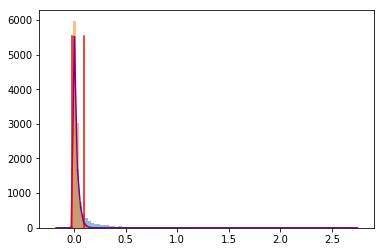

Got 9356 coords
After resolving overlaps, got 9356 seqlets
Across all tasks, the weakest transformed threshold used was: 0.519814596273292
MEMORY 3.32365824
9356 identified in total
Reducing weak_threshold_for_counting_sign to match weakest_transformed_thresh, from 0.8 to 0.519814596273292
2 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [8719, 637]
Idx to activities:  {0: '1', 1: '-1'}
MEMORY 3.324145664


In [13]:
import modisco
from collections import OrderedDict
import sys


def print_memory_use():
    import os
    import psutil
    process = psutil.Process(os.getpid())
    print("MEMORY",process.memory_info().rss/1000000000)

FRAC_SEQS_TO_USE = 0.02
NUM_SEQS_TO_USE = int(FRAC_SEQS_TO_USE*len(nanog_profile_wn_contribs))
print("num seqs to use:", NUM_SEQS_TO_USE)

task_names=["Nanog_profile_wn"]
contrib_scores={'Nanog_profile_wn':
                 nanog_profile_wn_contribs[:NUM_SEQS_TO_USE]}
hypothetical_contribs={'Nanog_profile_wn':
                       nanog_profile_wn_hypimp[:NUM_SEQS_TO_USE]}
one_hot=onehot_seq[:NUM_SEQS_TO_USE]
#null_tracks should either be a dictionary
# from task_name to 1d trakcs, or a callable
null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(
    num_to_samp=10000)
revcomp = True
plot_save_dir = "figures"

sliding_window_size = 21
flank_size = 10
histogram_bins = 100
percentiles_in_bandwidth = 10
overlap_portion = 0.5
min_metacluster_size = 100
min_metacluster_size_frac = 0.01
weak_threshold_for_counting_sign = 0.8
target_seqlet_fdr = 0.2
min_passing_windows_frac = 0.03
max_passing_windows_frac = 0.2
separate_pos_neg_thresholds = False
verbose = True
min_seqlets_per_task = None
other_tracks = []
#reducing from 50000 to 10000 for debugging purposes
max_seqlets_per_metacluster = 10000 #50000

overlap_resolver = modisco.core.SeqletsOverlapResolver(
    overlap_detector=modisco.core.CoordOverlapDetector(overlap_portion),
    seqlet_comparator=modisco.core.SeqletComparator(
       value_provider=
        modisco.value_provider.CoorScoreValueProvider()))

coord_producer = modisco.coordproducers.FixedWindowAroundChunks(
    sliding=sliding_window_size,
    flank=flank_size,
    suppress=(int(0.5*sliding_window_size)
              + flank_size),
    target_fdr=target_seqlet_fdr,
    min_passing_windows_frac=min_passing_windows_frac,
    max_passing_windows_frac=max_passing_windows_frac,
    separate_pos_neg_thresholds=separate_pos_neg_thresholds,
    max_seqlets_total=None,
    verbose=verbose,
    plot_save_dir=plot_save_dir) 

track_set = (modisco.tfmodisco_workflow.workflow.prep_track_set(
    task_names=task_names,
    contrib_scores=contrib_scores,
    hypothetical_contribs=hypothetical_contribs,
    one_hot=one_hot,
    revcomp=revcomp,
    other_tracks=other_tracks))

per_position_contrib_scores = OrderedDict([
    (x, [np.sum(s,axis=1) for s in contrib_scores[x]])
    for x in task_names])

multitask_seqlet_creation_results = modisco.core.MultiTaskSeqletCreator(
    coord_producer=coord_producer,
    overlap_resolver=overlap_resolver)(
        task_name_to_score_track=per_position_contrib_scores,
        null_tracks=null_per_pos_scores,
        track_set=track_set)

#find the weakest transformed threshold used across all tasks
weakest_transformed_thresh = (min(
    [min(x.tnt_results.transformed_pos_threshold,
         abs(x.tnt_results.transformed_neg_threshold))
         for x in (multitask_seqlet_creation_results.
                   task_name_to_coord_producer_results.values())]) -
    0.0001) #subtract 1e-4 to avoid weird numerical issues
print("Across all tasks, the weakest transformed threshold used"
      +" was: "+str(weakest_transformed_thresh))
print_memory_use()

all_seqlets = multitask_seqlet_creation_results.final_seqlets
print(str(len(all_seqlets))+" identified in total")
if (len(all_seqlets) < 100):
    print("WARNING: you found relatively few seqlets."
          +" Consider dropping target_seqlet_fdr") 

if int(min_metacluster_size_frac * len(all_seqlets)) > min_metacluster_size:
    print("min_metacluster_size_frac * len(seqlets) = {0} is more than min_metacluster_size={1}.".\
          format(int(min_metacluster_size_frac * len(all_seqlets)), min_metacluster_size))
    print("Using it as a new min_metacluster_size")
    min_metacluster_size = int(min_metacluster_size_frac * len(all_seqlets))

weak_threshold_for_counting_sign=0.8
if (weak_threshold_for_counting_sign is None):
    weak_threshold_for_counting_sign = weakest_transformed_thresh
else:
    weak_threshold_for_counting_sign =\
        weak_threshold_for_counting_sign
    
if (weak_threshold_for_counting_sign > weakest_transformed_thresh):
    print("Reducing weak_threshold_for_counting_sign to"
          +" match weakest_transformed_thresh, from "
          +str(weak_threshold_for_counting_sign)
          +" to "+str(weakest_transformed_thresh))
    weak_threshold_for_counting_sign = weakest_transformed_thresh

task_name_to_value_provider = OrderedDict([
    (task_name,
     modisco.value_provider.TransformCentralWindowValueProvider(
        track_name=task_name+"_contrib_scores",
        central_window=sliding_window_size,
        val_transformer= 
         coord_producer_results.tnt_results.val_transformer))
     for (task_name,coord_producer_results)
         in (multitask_seqlet_creation_results.
             task_name_to_coord_producer_results.items())])

min_metacluster_size=100
metaclusterer = modisco.metaclusterers.SignBasedPatternClustering(
                        min_cluster_size=min_metacluster_size,
                        task_name_to_value_provider=
                            task_name_to_value_provider,
                        task_names=task_names,
                        threshold_for_counting_sign=
                            weakest_transformed_thresh,
                        weak_threshold_for_counting_sign=
                            weak_threshold_for_counting_sign)

metaclustering_results = metaclusterer.fit_transform(all_seqlets)
metacluster_indices = np.array(
    metaclustering_results.metacluster_indices)
metacluster_idx_to_activity_pattern =\
    metaclustering_results.metacluster_idx_to_activity_pattern

num_metaclusters = max(metacluster_indices)+1
metacluster_sizes = [np.sum(metacluster_idx==metacluster_indices)
                      for metacluster_idx in range(num_metaclusters)]
if (verbose):
    print("Metacluster sizes: ",metacluster_sizes)
    print("Idx to activities: ",metacluster_idx_to_activity_pattern)
    print_memory_use()
    sys.stdout.flush()

In [14]:
metacluster_idx = 0
metacluster_size = metacluster_sizes[metacluster_idx]
print("On metacluster "+str(metacluster_idx))                       
if (max_seqlets_per_metacluster is None                        
    or max_seqlets_per_metacluster >= metacluster_size):       
    print("Metacluster size", metacluster_size)                     
else:                                                               
    print("Metacluster size {0} limited to {1}".format(             
            metacluster_size, max_seqlets_per_metacluster))    
sys.stdout.flush()                                                  
metacluster_activities = [                                          
    int(x) for x in                                                 
    metacluster_idx_to_activity_pattern[metacluster_idx].split(",")]
assert len(all_seqlets)==len(metacluster_indices)                       
metacluster_seqlets = [                                             
    x[0] for x in zip(all_seqlets, metacluster_indices)                 
    if x[1]==metacluster_idx][:max_seqlets_per_metacluster]    
relevant_task_names, relevant_task_signs =\
    zip(*[(x[0], x[1]) for x in                                     
        zip(task_names, metacluster_activities) if x[1] != 0])      
print('Relevant tasks: ', relevant_task_names)                      
print('Relevant signs: ', relevant_task_signs)                      
sys.stdout.flush()                                                  
if (len(relevant_task_names) == 0):                                 
    assert False, "This should not happen"                          
    sys.stdout.flush()                                              

onehot_track_name="sequence"
contrib_scores_track_names = [key+"_contrib_scores" for key in relevant_task_names]
hypothetical_contribs_track_names= [key+"_hypothetical_contribs" for key in relevant_task_names]                
track_signs=relevant_task_signs                              
other_comparison_track_names=[]



assert len(track_signs)==len(hypothetical_contribs_track_names)         
assert len(track_signs)==len(contrib_scores_track_names)                
                                                                                
seqlets_sorter = (lambda arr:                                           
                          sorted(arr,                                           
                                 key=lambda x:                                  
                                  -np.sum([np.sum(np.abs(x[track_name].fwd))    
                                     for track_name                             
                                     in contrib_scores_track_names])))

min_overlap_while_sliding = 0.7
pattern_comparison_settings =\
            modisco.affinitymat.core.PatternComparisonSettings(                         
                track_names=hypothetical_contribs_track_names                   
                            +contrib_scores_track_names                         
                            +other_comparison_track_names,                      
                track_transformer=modisco.affinitymat.L1Normalizer(),                   
                min_overlap=min_overlap_while_sliding)

#coarse_grained 1d embedder   
embedder_factory=(modisco.seqlet_embedding
                          .onehot_model_output.KerasModelOutputEmbedder
                          .get_factory(model_h5="embedding_model.h5"))
seqlets_to_1d_embedder = embedder_factory(                         
        onehot_track_name=onehot_track_name,                            
        toscore_track_names_and_signs=list(                             
        zip(hypothetical_contribs_track_names,                          
            [np.sign(x) for x in track_signs])))

#affinity matrix from embeddings                                        
coarse_affmat_computer =\
    modisco.affinitymat.core.AffmatFromSeqletEmbeddings(                        
        seqlets_to_1d_embedder=seqlets_to_1d_embedder,                  
        affinity_mat_from_1d=\
            modisco.affinitymat.core.NumpyCosineSimilarity(                     
                verbose=True,                                   
                gpu_batch_size=None),                                   
        verbose=True)                                           

affmat_from_seqlets_with_nn_pairs =\
    modisco.affinitymat.core.AffmatFromSeqletsWithNNpairs(                      
        pattern_comparison_settings=pattern_comparison_settings,        
        sim_metric_on_nn_pairs=\
            modisco.affinitymat.core.ParallelCpuCrossMetricOnNNpairs(           
                n_cores=10,                                   
                cross_metric_single_region=                             
                    modisco.affinitymat.core.CrossContinJaccardSingleRegion()))

seqlets = seqlets_sorter(metacluster_seqlets)
print("Computing coarse affmat", flush=True)
coarse_affmat = coarse_affmat_computer(seqlets)
print("Computing seqlet neighbors from coarse", flush=True)
seqlet_neighbors = (modisco.tfmodisco_workflow.seqlets_to_patterns
    .get_seqlet_neighbors_with_initcluster(       
        nearest_neighbors_to_compute=500,                         
        coarse_affmat=coarse_affmat,                                
        initclusters=None))
print("Computing fine-grained", flush=True)
affmat_from_seqlets_with_nn_pairs_argmax =\
    modisco.affinitymat.core.AffmatFromSeqletsWithNNpairs(
        pattern_comparison_settings=pattern_comparison_settings,
        sim_metric_on_nn_pairs=\
            modisco.affinitymat.core.ParallelCpuCrossMetricOnNNpairs(
                n_cores=10,
                cross_metric_single_region=
                    modisco.affinitymat.core.CrossContinJaccardSingleRegionWithArgmax()))

On metacluster 0
Metacluster size 8719
Relevant tasks:  ('Nanog_profile_wn',)
Relevant signs:  (1,)
Computing coarse affmat
Beginning embedding computation


/users/avanti/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Finished embedding computation in 17.37 s
Starting affinity matrix computations
Normalization computed in 0.12 s
Cosine similarity mat computed in 1.34 s
Normalization computed in 0.07 s
Cosine similarity mat computed in 1.24 s
Finished affinity matrix computations in 3.55 s
Computing seqlet neighbors from coarse
Computing fine-grained


In [34]:
from modisco.visualization import viz_sequence


def max_window_sum(ic_vals, window_size=6):
    per_pos_tot_ic = np.sum(ic_vals, axis=-1)
    cumsum = np.cumsum([0]+list(per_pos_tot_ic))
    return np.max(cumsum[window_size:] - cumsum[:-window_size])


def get_aligned_coordinates_for_premotif(sparse_nn_affmat_withargmax_row,
                                         seqlet_neighbors_row,
                                         seqlets,
                                         num_in_premotif):
    #subset to the num_in_premotif most similar
    argsort_indices = np.argsort(-sparse_nn_affmat_withargmax_row[:,0])[:num_in_premotif]
    seqlet_indices = np.array([seqlet_neighbors_row[i] for i in argsort_indices])
    isfwd = sparse_nn_affmat_withargmax_row[:,2][argsort_indices]
    #flip sign of offset if on reverse strand
    offsets = (sparse_nn_affmat_withargmax_row[:,1][argsort_indices])*(2*isfwd - 1)
    coords_to_return = []
    for seqlet_idx,offset,isfwd in zip(seqlet_indices,offsets,isfwd):
        new_coor = modisco.core.SeqletCoordinates(
            example_idx=seqlets[seqlet_idx].coor.example_idx,
            start=int(seqlets[seqlet_idx].coor.start-offset),
            end=int(seqlets[seqlet_idx].coor.end-offset),
            #flip is_revcomp according to value of isfwd
            is_revcomp=(seqlets[seqlet_idx].coor.is_revcomp==(isfwd==1.0)))
        coords_to_return.append(new_coor)
    return coords_to_return


def get_premotif_avgonehot(datatrack, **kwargs):
    coords = get_aligned_coordinates_for_premotif(**kwargs)
    to_avg = []
    for coor in coords:
        if (coor.start >= 0 and
            coor.end <= len(datatrack.fwd_tracks[coor.example_idx])):
            to_avg.append(datatrack.get_snippet(coor=coor).fwd)
    return np.mean(to_avg, axis=0)


def get_premotif_avgseqlets(track_set, **kwargs):
    coords = get_aligned_coordinates_for_premotif(**kwargs)
    premotif = modisco.core.Pattern()
    for track_name, datatrack in track_set.track_name_to_data_track.items():
        fwd_to_avg = []
        rev_to_avg = []
        for coor in coords:
            if (coor.start >= 0 and
                coor.end <= len(datatrack.fwd_tracks[coor.example_idx])):
                fwd_to_avg.append(datatrack.get_snippet(coor=coor).fwd)
                rev_to_avg.append(datatrack.get_snippet(coor=coor).rev)
        fwd = np.mean(fwd_to_avg, axis=0)
        rev = np.mean(rev_to_avg, axis=0)
        #if (track_name=="sequence"):
        #    fullconv = np.mean(fullconv_model.predict(np.array(fwd_to_avg)), axis=0)
        snippet = modisco.core.Snippet(fwd=fwd, rev=rev, has_pos_axis=True)
        premotif.track_name_to_snippet[track_name] = snippet
    return premotif#, fullconv
    
bg_freq = np.mean(onehot_seq, axis=(0,1))

NUM_IN_PREMOTIF=20
round_sparse_nn_affmat_withargmax = []
round_premotif_avgseqlets = []
round_fullconv_avgseqlets = []
round_premotif_ics = []
current_seqlets = seqlets
for roundnumber in range(1): 
    print("ROUND NUMBER",roundnumber)
    sparse_nn_affmat_withargmax = affmat_from_seqlets_with_nn_pairs_argmax(
        seqlet_neighbors=seqlet_neighbors,
        seqlets=current_seqlets,
        return_sparse=True)
    round_sparse_nn_affmat_withargmax.append(sparse_nn_affmat_withargmax)

    premotif_avgseqlets = []
    #fullconv_avgseqlets = []
    for idx in range(len(seqlets)):
        #premotif, fullconv = get_premotif_avgseqlets(
        premotif = get_premotif_avgseqlets(
            track_set=track_set,
            sparse_nn_affmat_withargmax_row=sparse_nn_affmat_withargmax[idx],
            seqlet_neighbors_row=seqlet_neighbors[idx],
            seqlets=seqlets,
            num_in_premotif=NUM_IN_PREMOTIF)
        premotif_avgseqlets.append(premotif)
        #fullconv_avgseqlets.append(fullconv)
    round_premotif_avgseqlets.append(premotif_avgseqlets)
    #round_fullconv_avgseqlets.append(fullconv_avgseqlets)
    
    premotif_ics = np.array([
        max_window_sum(viz_sequence.ic_scale(
            pwm=premotif_avgseqlet["sequence"].fwd,
            background=bg_freq))
        for premotif_avgseqlet in premotif_avgseqlets])
    round_premotif_ics.append(premotif_ics)
    
    current_seqlets = premotif_avgseqlets

ROUND NUMBER 0
Launching nearest neighbors affmat calculation job
MEMORY 6.189154304
Parallel runs completed
MEMORY 6.189346816
Job completed in: 58.92 s
MEMORY 6.187655168
Launching nearest neighbors affmat calculation job
MEMORY 6.184067072
Parallel runs completed
MEMORY 6.184308736
Job completed in: 61.03 s
MEMORY 6.184308736


In [49]:
fullconv_raw_embedding_fwd = np.array(fullconv_model.predict(
                          np.array([x["sequence"].fwd for x in seqlets])))
fullconv_raw_embedding_rev = np.array(fullconv_model.predict(
                          np.array([x["sequence"].rev for x in seqlets])))

concatenated_fullconv_raw = np.concatenate([fullconv_raw_embedding_fwd, fullconv_raw_embedding_rev], axis=0)

In [55]:
#normalize it
channel_means = np.mean(concatenated_fullconv_raw, axis=(0,1))
channel_std = np.std(concatenated_fullconv_raw, axis=(0,1))

fullconv_normed_embedding_fwd = fullconv_raw_embedding_fwd - channel_means[None,None,:]
fullconv_normed_embedding_rev = fullconv_raw_embedding_rev - channel_means[None,None,:]

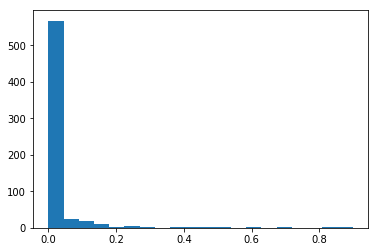

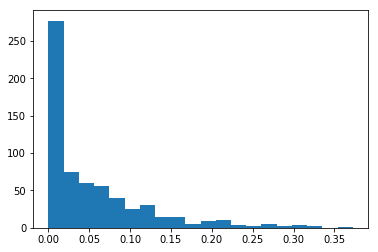

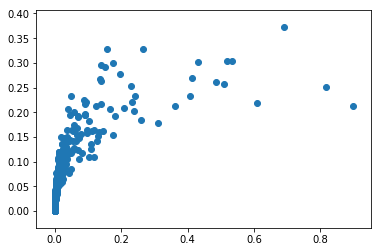

In [56]:
plt.hist(channel_means, bins=20)
plt.show()
plt.hist(channel_std, bins=20)
plt.show()
plt.scatter(channel_means, channel_std)
plt.show()

In [131]:
#let's attempt some kind of constellation-based similarity
#for each embedding, let's consider the top N positions. Then the
# top N*N-1 will define the constellations.

from collections import namedtuple, Counter

StarPair = namedtuple("FeaturePair", [
    "feature1_channel_idx", "feature2_channel_idx",
    "gap", "offsetfromstart",
    "feature1_channel_val", "feature2_channel_val"])


class Constellation(object):
    
    def __init__(self, starpairs):
        self.starpairs = starpairs
        self.process_starpairs(self.starpairs)
        
    def process_starpairs(self, starpairs):
        #need a dict of channel1idx+gap+channel2idx -> offsetfromstart
        starpair_to_offsetfromstart = {}
        for starpair in starpairs:
            starpair_to_offsetfromstart[
                (starpair.feature1_channel_idx,
                 starpair.gap,
                 starpair.feature2_channel_idx)] = starpair.offsetfromstart
        self.starpair_to_offsetfromstart = starpair_to_offsetfromstart
    
    def get_best_offset(self, other_constellation):
        offsets = []
        for starpair1 in self.starpair_to_offsetfromstart.keys():
            if starpair1 in other_constellation.starpair_to_offsetfromstart:
                offsets.append(
                    other_constellation.starpair_to_offsetfromstart[starpair1]
                    - self.starpair_to_offsetfromstart[starpair1])
        offset_counts = Counter(offsets)
        if (len(offset_counts) > 0):
            (best_offset, offset_count) = max(offset_counts.items(), key=lambda x: x[1])
        else:
            (best_offset, offset_count) = (0,0)
        return (best_offset, offset_count)


def make_constellation(fullconv_norm_embedding, topn):
    #sort neurons by absolute value
    top_neurons_indices = list(zip(*np.unravel_index(np.argsort(
        -np.abs(fullconv_norm_embedding.ravel()) ),
        fullconv_norm_embedding.shape)))
    
    starpairs = []
    #take the first topn and make a constellation
    for i in range(topn):
        for j in range(i+1, topn):
            featurea_idxs = top_neurons_indices[i]
            featureb_idxs = top_neurons_indices[j]
            #feature1 is the one that is to the left
            if (featurea_idxs[0] < featureb_idxs[0]):
                feature1_idxs = featurea_idxs
                feature2_idxs = featureb_idxs
            else:
                feature1_idxs = featureb_idxs
                feature2_idxs = featurea_idxs
            offsetfromstart = feature1_idxs[0]
            feature1_channel_idx = feature1_idxs[1]
            feature2_channel_idx = feature2_idxs[1]
            gap = feature2_idxs[0] - feature1_idxs[0]
            feature1_channel_val = fullconv_norm_embedding[
                feature1_idxs[0], feature1_idxs[1]]
            feature2_channel_val = fullconv_norm_embedding[
                feature2_idxs[0], feature2_idxs[1]]
            starpairs.append(
                StarPair(feature1_channel_idx=feature1_channel_idx,
                            feature2_channel_idx=feature2_channel_idx,
                            gap=gap, offsetfromstart=offsetfromstart,
                            feature1_channel_val=feature1_channel_val,
                            feature2_channel_val=feature2_channel_val) )
    
    return Constellation(starpairs=starpairs)
    

def get_constellation_pairwise_sims(constellation_list1, constellation_list2):
    pairwise_sims = np.zeros((len(constellation_list1), len(constellation_list2)))
    offsets = np.zeros((len(constellation_list1), len(constellation_list2)))
    for i in range(len(constellation_list1)):
        if (i%100==0):
            print("Done",i)
        for j in range(len(constellation_list2)):
            (offset, sim) = constellation_list1[i].get_best_offset(other_constellation=constellation_list2[j])
            pairwise_sims[i,j] = sim
            offsets[i,j] = offset
    return pairwise_sims, offsets


def get_n_nearest_neighbors(sim_mat, n):
    return [np.argsort(-row)[:n] for row in sim_mat]

In [122]:
TOPN = 30
constellations_fwd = [make_constellation(fullconv_norm_embedding=x, topn=TOPN)
                      for x in fullconv_normed_embedding_fwd[::10] ]

In [125]:
pairwise_sims_fwd, offsets_fwd = get_constellation_pairwise_sims(
    constellation_list1=constellations_fwd,
    constellation_list2=constellations_fwd)

Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800


In [132]:
nearest_neighbors = get_n_nearest_neighbors(sim_mat=pairwise_sims_fwd,
                                            n=50)

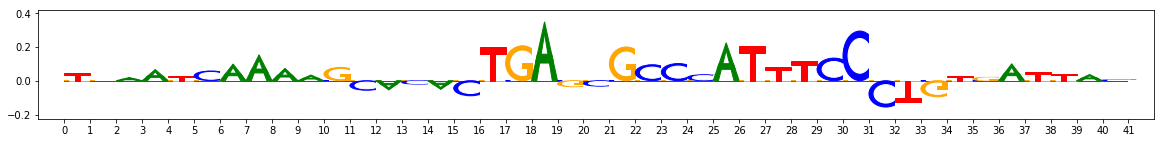

Neighbor: 10


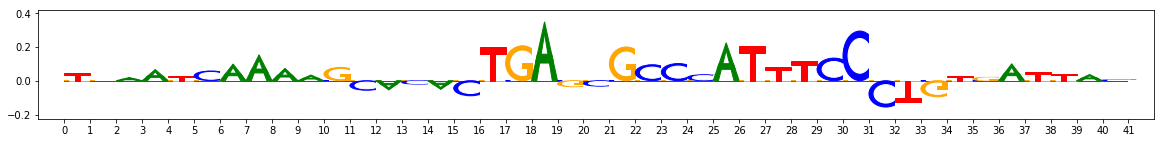

Neighbor: 360


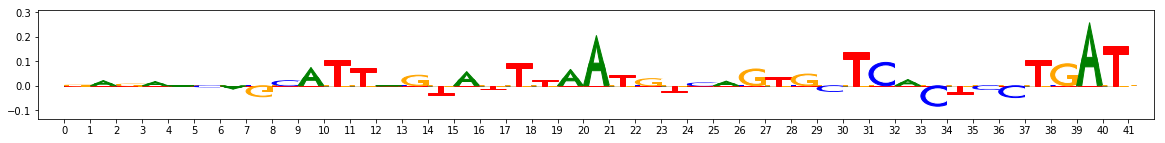

Neighbor: 4


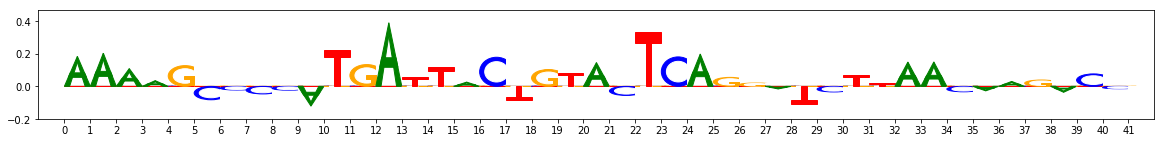

Neighbor: 2


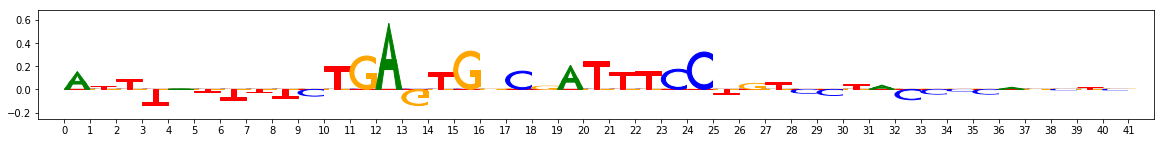

Neighbor: 514


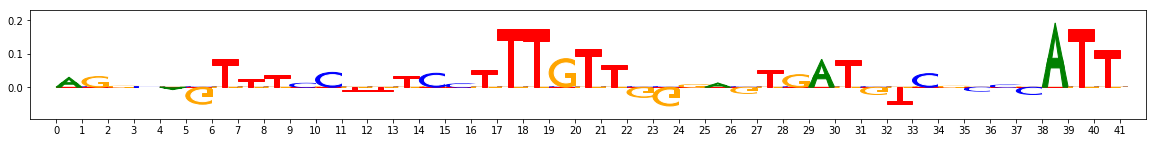

In [135]:
idx_to_viz = 10
viz_sequence.plot_weights(seqlets[idx_to_viz]["Nanog_profile_wn_contrib_scores"].fwd)
for neighbor_idx in nearest_neighbors[idx_to_viz][:5]:
    print("Neighbor:",neighbor_idx)
    viz_sequence.plot_weights(seqlets[neighbor_idx]["Nanog_profile_wn_contrib_scores"].fwd)

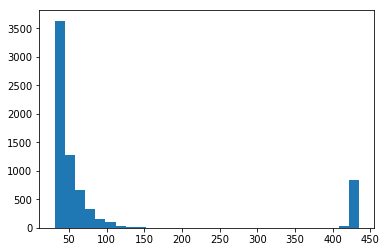

In [129]:
plt.hist(pairwise_sims_fwd.ravel()[pairwise_sims_fwd.ravel() > 30], bins=30)
plt.show()

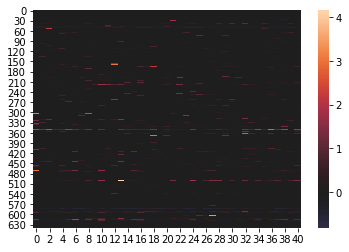

In [66]:
sns.heatmap(fullconv_normed_embedding_fwd[0].transpose((1,0)), center=0)

In [35]:
import scipy


def reconstitute_dense_affmat(sparse_affmat_withargmax, seqlet_neighbors):
    to_return = np.zeros((len(seqlet_neighbors), len(seqlet_neighbors)))
    for row_idx, (neighbors, affinitieswithargmax) in enumerate(zip(seqlet_neighbors, sparse_affmat_withargmax)):
        affinities = affinitieswithargmax[:,0]
        for col_idx, val in zip(neighbors, affinities):
            to_return[row_idx, col_idx] = val
    return to_return


def get_correlations(main_affmat, other_affmat):
    correlations = []
    for main_affmat_row, other_affmat_row\
        in zip(main_affmat, other_affmat):
        #compare correlation on the nonzero rows
        to_compare_mask = np.abs(main_affmat_row) > 0
        corr = scipy.stats.spearmanr(
                main_affmat_row[to_compare_mask],
                other_affmat_row[to_compare_mask])
        correlations.append(corr.correlation)
    correlations = np.array(correlations)
    return correlations

round_correlations = [get_correlations(main_affmat=reconstitute_dense_affmat(
                                    sparse_affmat_withargmax=sparse_nn_affmat_withargmax,
                                    seqlet_neighbors=seqlet_neighbors),
                                other_affmat=coarse_affmat)
                      for sparse_nn_affmat_withargmax in round_sparse_nn_affmat_withargmax]

Round idx 0
ICs:
0.0848721183621975


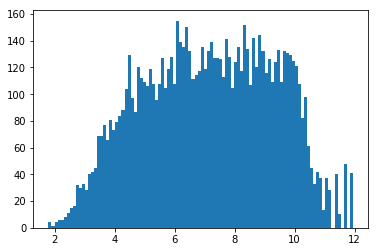

Embedding correlations:
0.12765225369881866


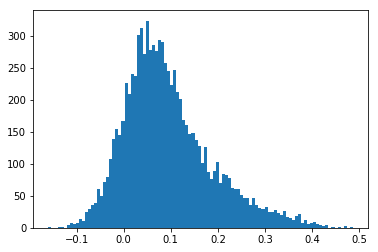

In [36]:
from matplotlib import pyplot as plt

thresh = 4

for idx,(premotif_ics,correlations) in enumerate(zip(round_premotif_ics, round_correlations)):
    print("Round idx", idx)
    print("ICs:")
    plt.hist(premotif_ics, bins=100)
    print(np.mean(premotif_ics < thresh))
    plt.show()
    print("Embedding correlations:")
    plt.hist(correlations, bins=100)
    print(np.mean(correlations < 0))
    plt.show()

#######################
FILTERING PERCENTILE: 0.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 1.7923325598239899)
Coordinate:  example:1066,start:541,end:582,rc:False
Contrib scores:


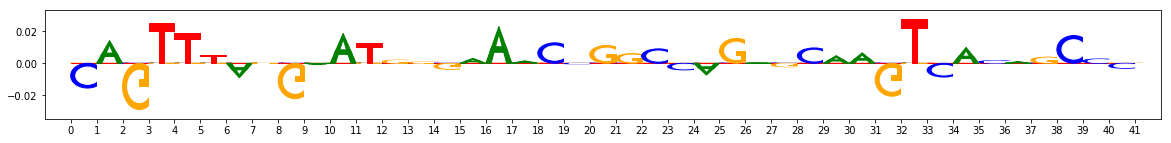

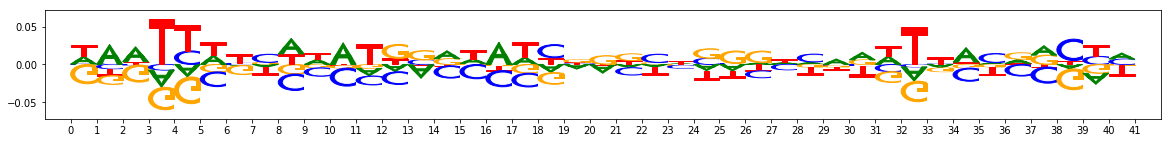

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 1.7923325598239899


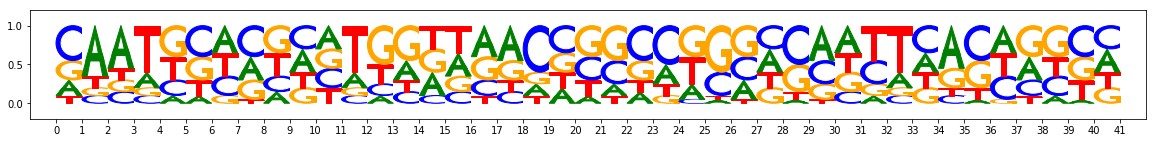

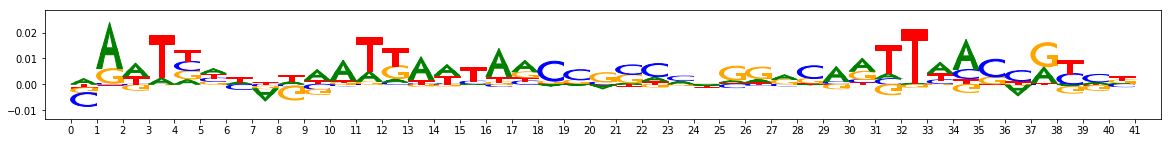

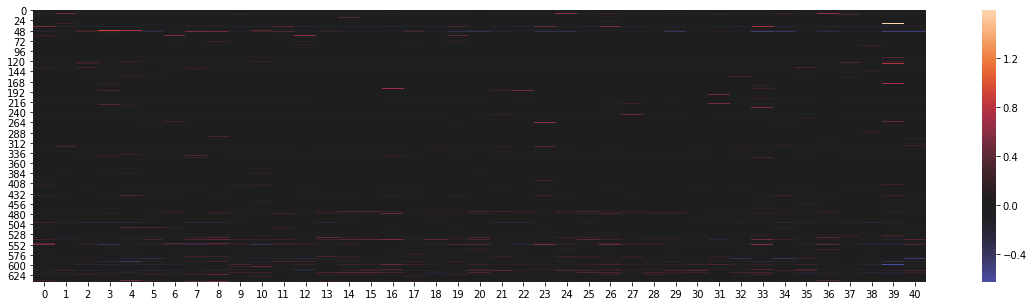

Round correlation -0.07416399074361238
#######################
FILTERING PERCENTILE: 5.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 3.5737228095531464)
Coordinate:  example:644,start:507,end:548,rc:False
Contrib scores:


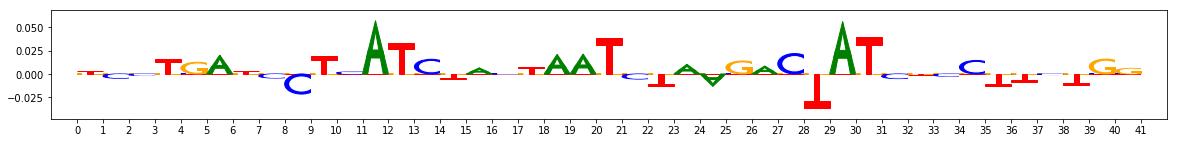

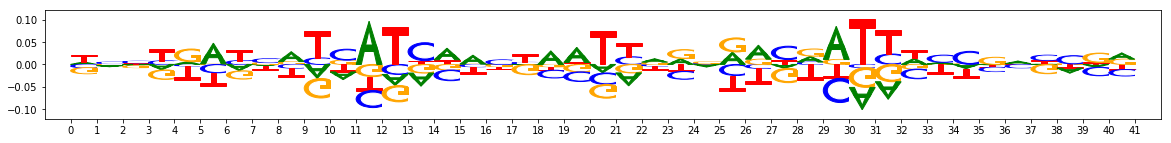

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 3.5737228095531464


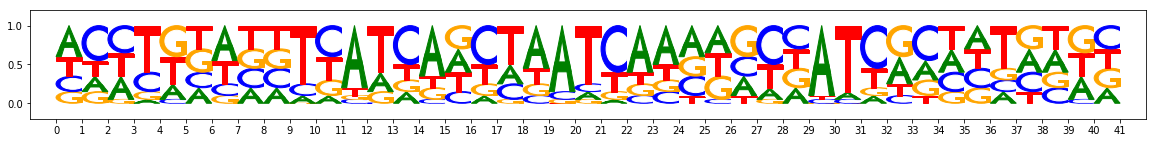

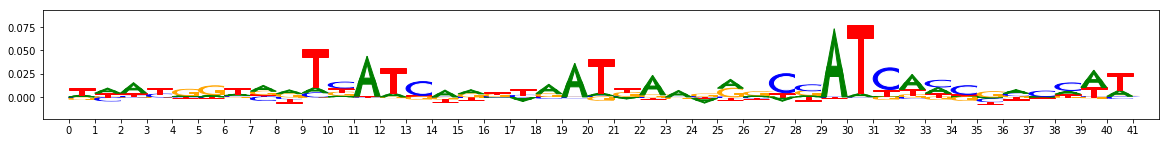

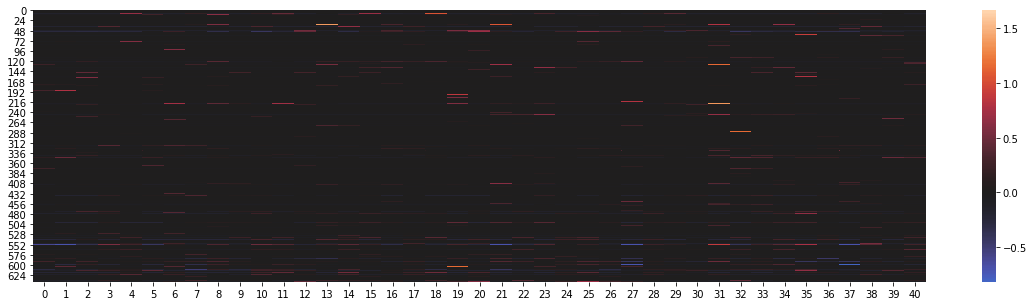

Round correlation 0.026802015421095237
#######################
FILTERING PERCENTILE: 10.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 4.160258620977402)
Coordinate:  example:882,start:515,end:556,rc:False
Contrib scores:


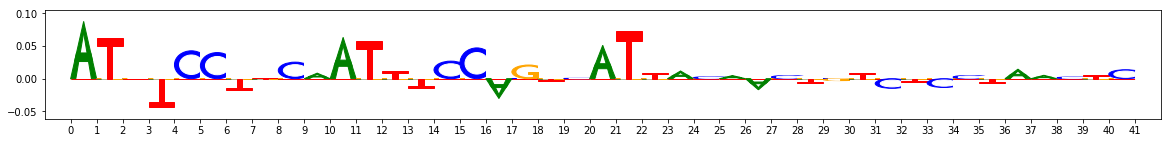

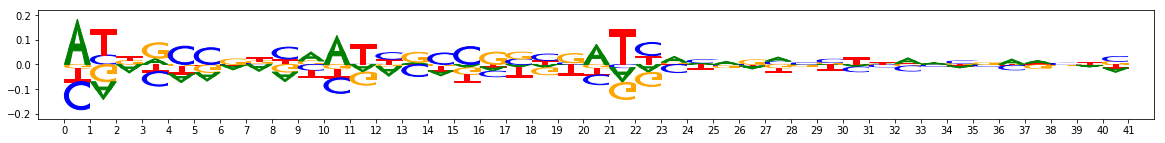

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 4.160258620977402


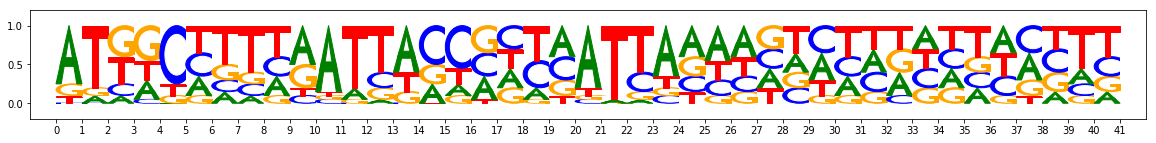

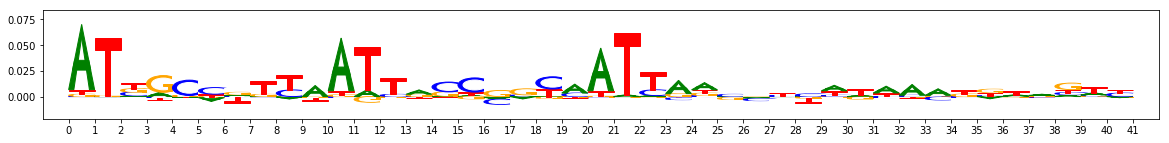

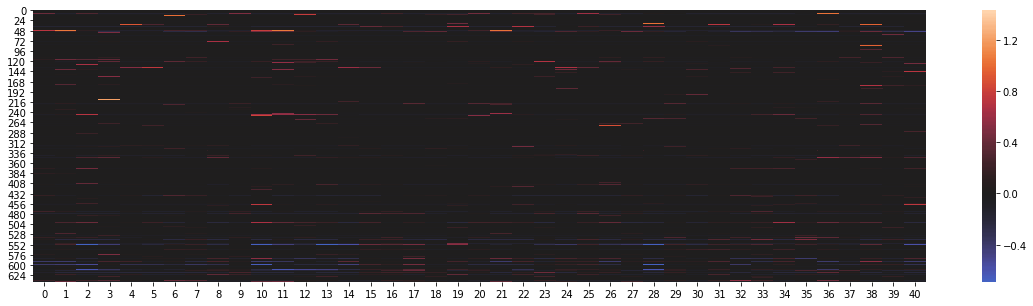

Round correlation -0.05020922658176122
#######################
FILTERING PERCENTILE: 15.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 4.599989026784897)
Coordinate:  example:455,start:500,end:541,rc:False
Contrib scores:


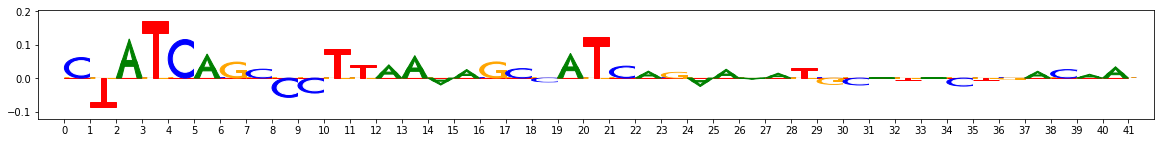

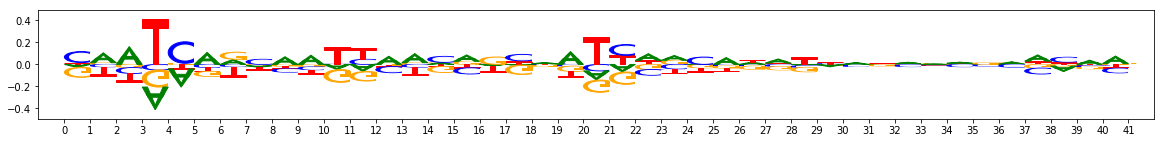

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 4.599989026784897


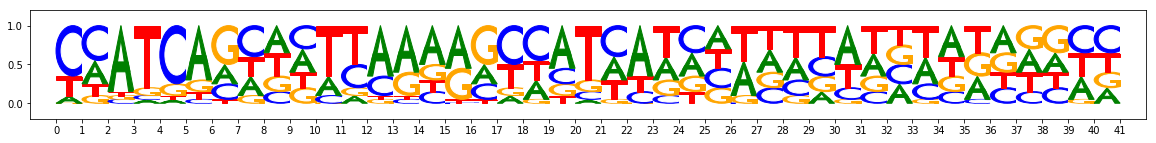

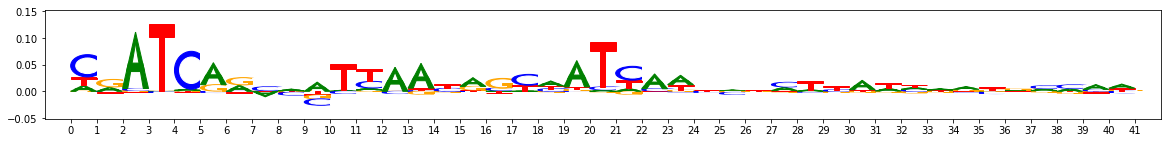

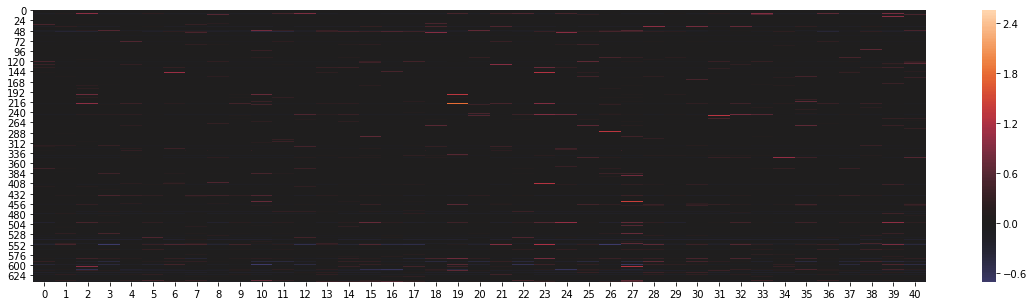

Round correlation 0.13615607357769105
#######################
FILTERING PERCENTILE: 20.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 5.014316409826279)
Coordinate:  example:10,start:384,end:425,rc:False
Contrib scores:


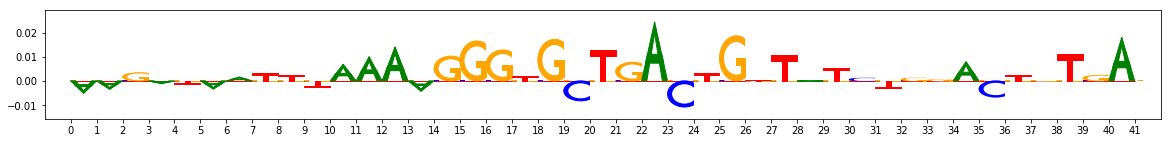

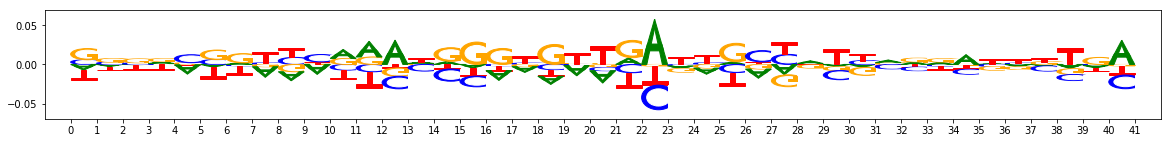

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 5.014316409826279


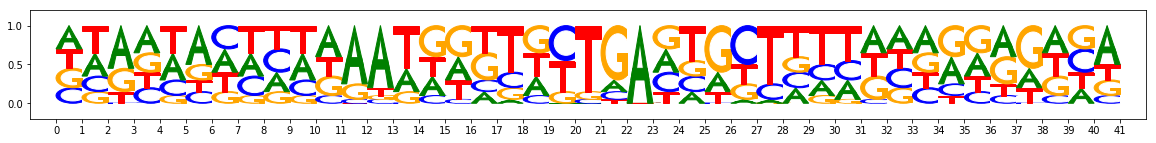

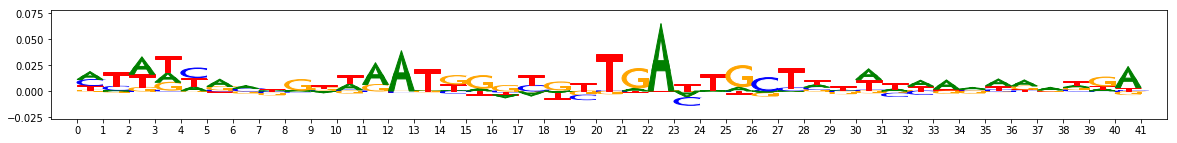

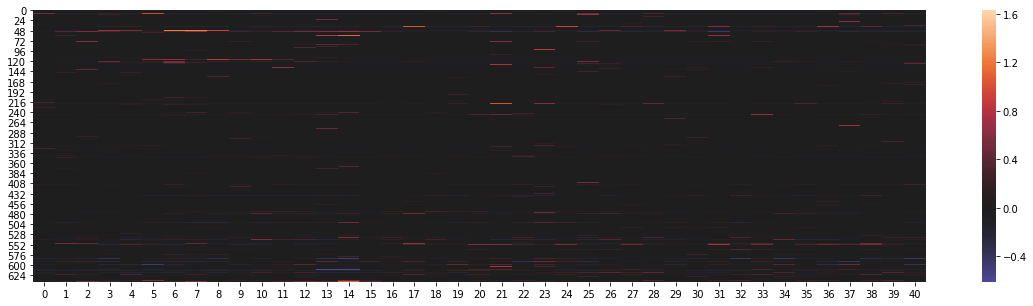

Round correlation -0.00864956938712217
#######################
FILTERING PERCENTILE: 25.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 5.4208575785160065)
Coordinate:  example:968,start:507,end:548,rc:False
Contrib scores:


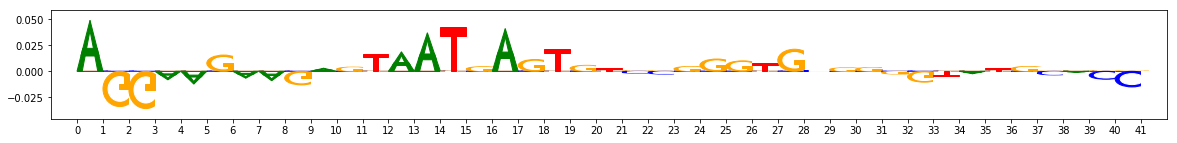

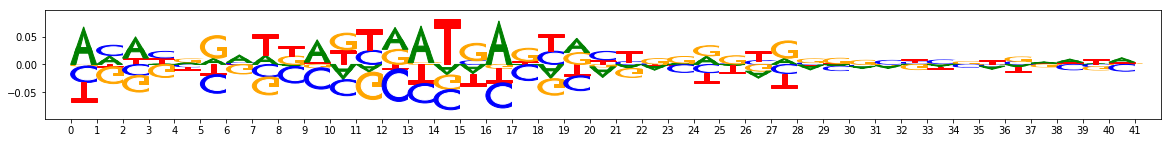

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 5.4208575785160065


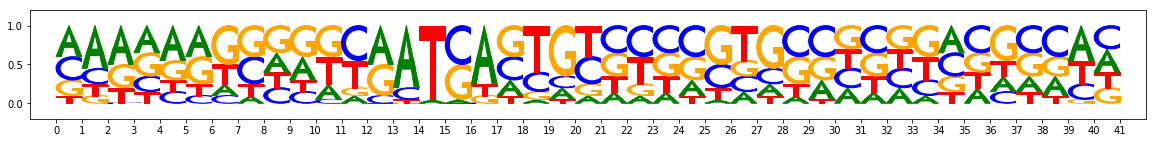

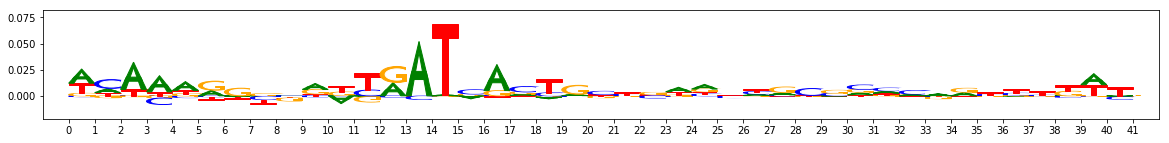

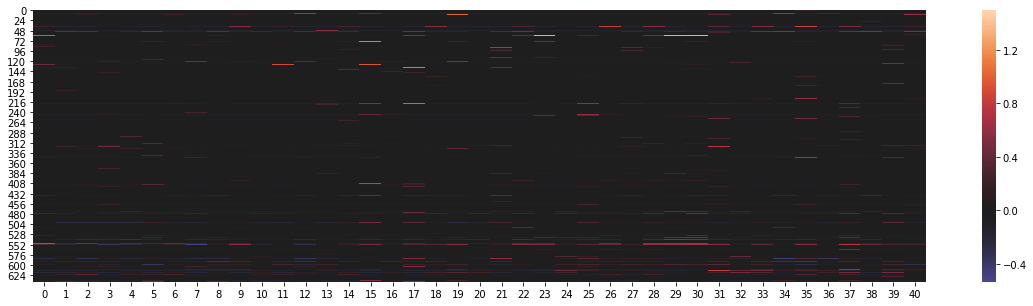

Round correlation 0.09648848915714389
#######################
FILTERING PERCENTILE: 30.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 5.804835498332977)
Coordinate:  example:60,start:620,end:661,rc:False
Contrib scores:


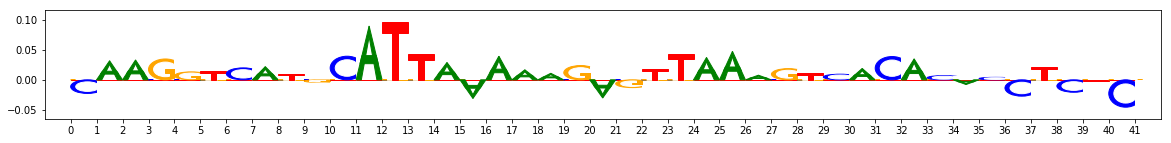

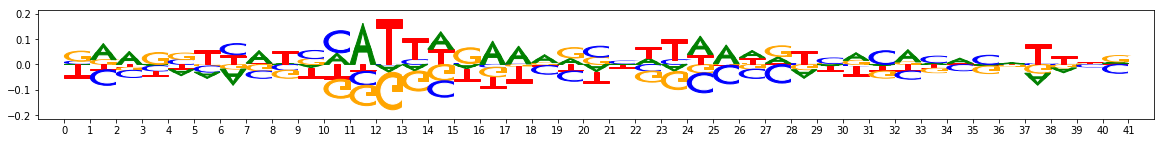

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 5.804835498332977


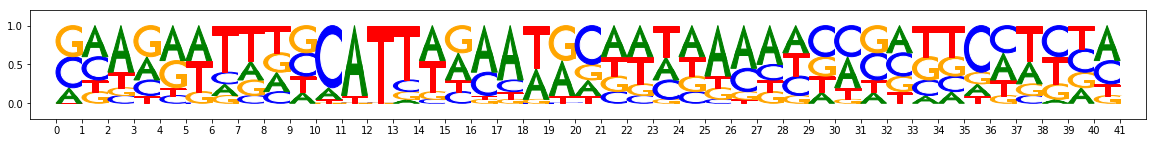

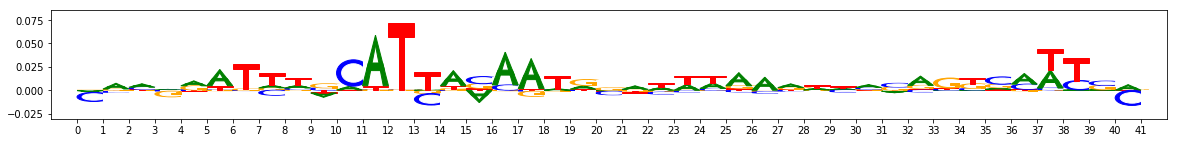

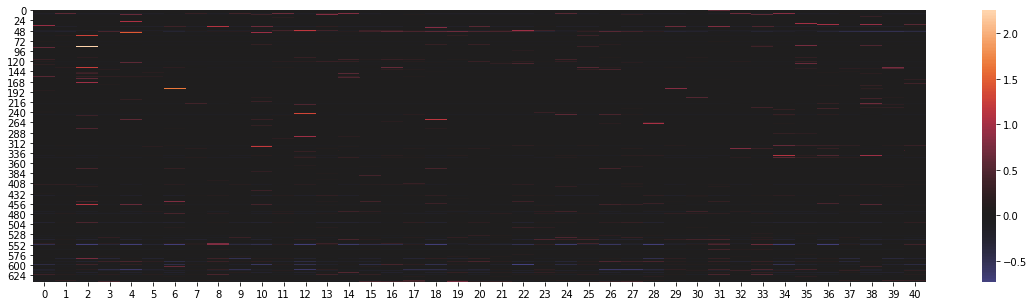

Round correlation 0.01956218334146928
#######################
FILTERING PERCENTILE: 35.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 6.156921327114105)
Coordinate:  example:852,start:356,end:397,rc:False
Contrib scores:


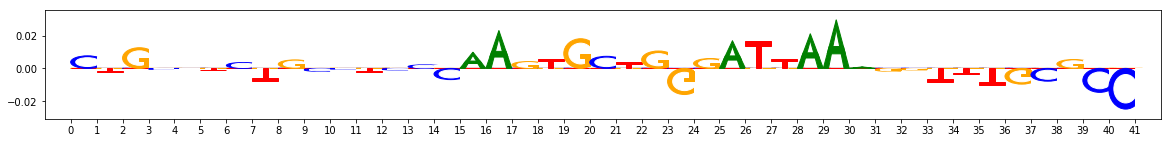

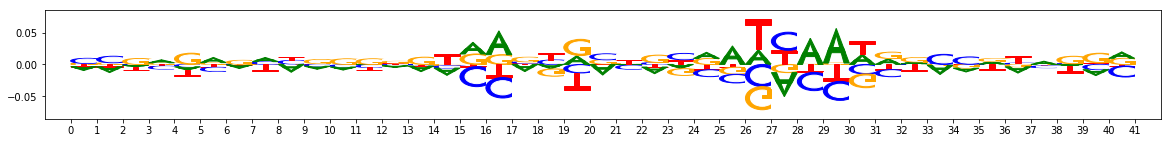

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 6.156921327114105


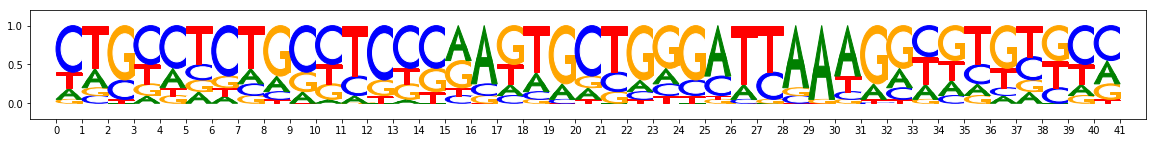

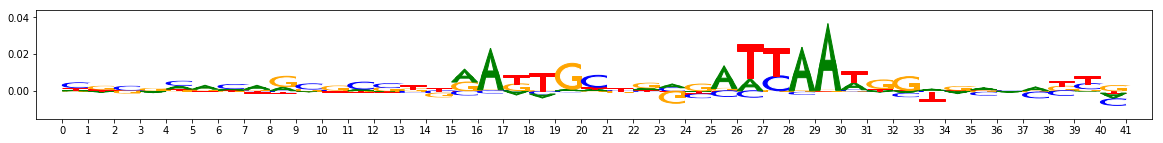

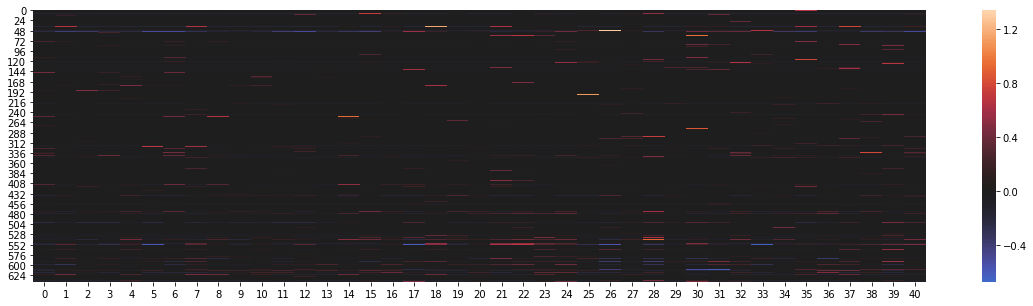

Round correlation 0.07055596423360075
#######################
FILTERING PERCENTILE: 40.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 6.466616243124008)
Coordinate:  example:268,start:428,end:469,rc:False
Contrib scores:


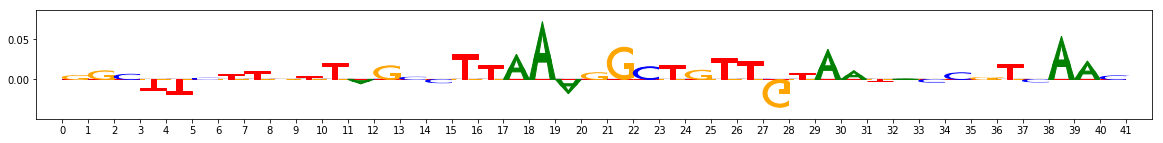

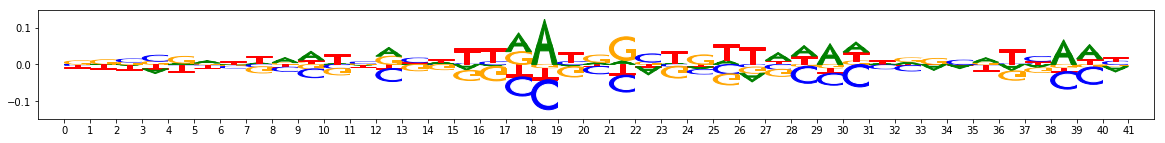

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 6.466616243124008


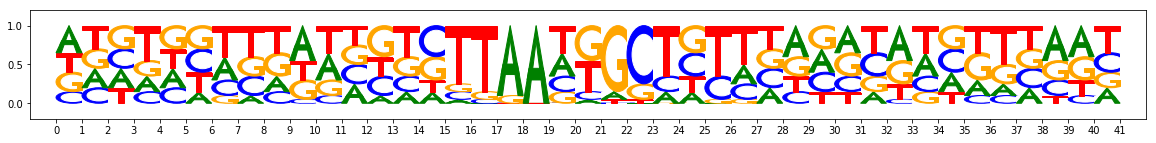

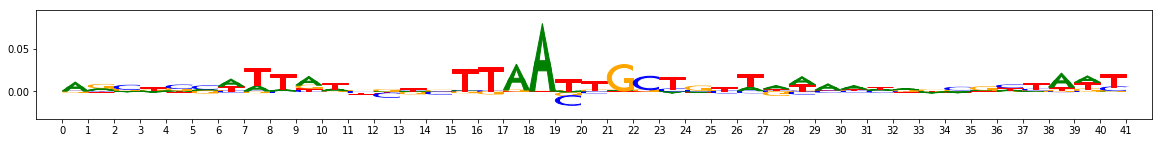

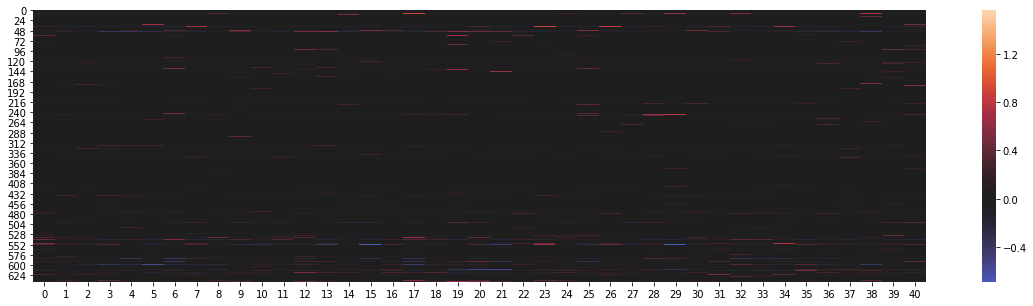

Round correlation 0.051232293609568776
#######################
FILTERING PERCENTILE: 45.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 6.836043477058411)
Coordinate:  example:55,start:422,end:463,rc:False
Contrib scores:


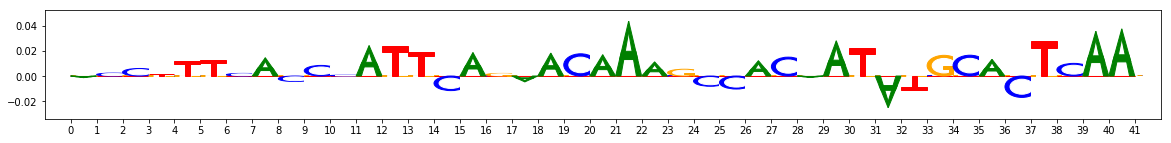

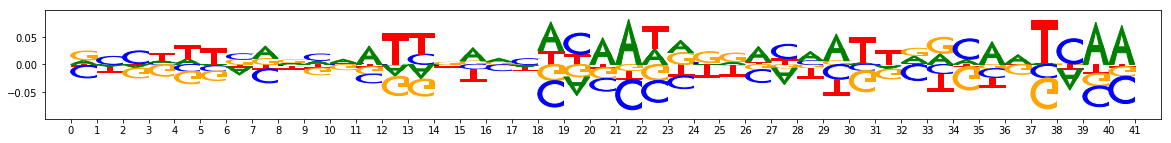

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 6.836043477058411


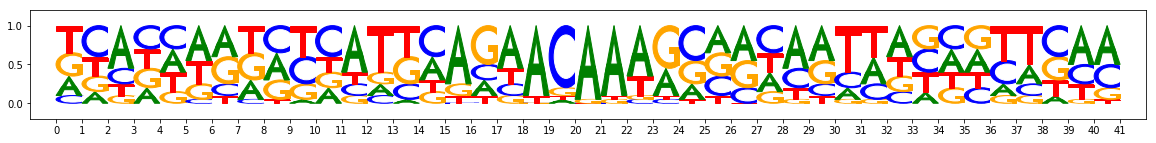

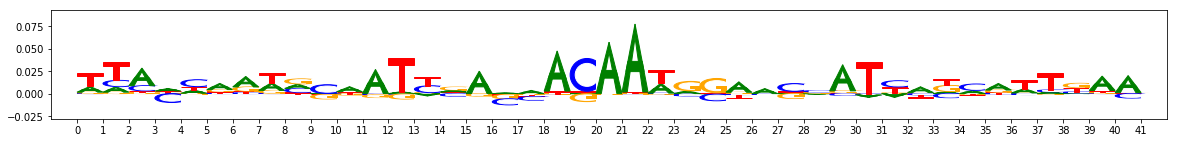

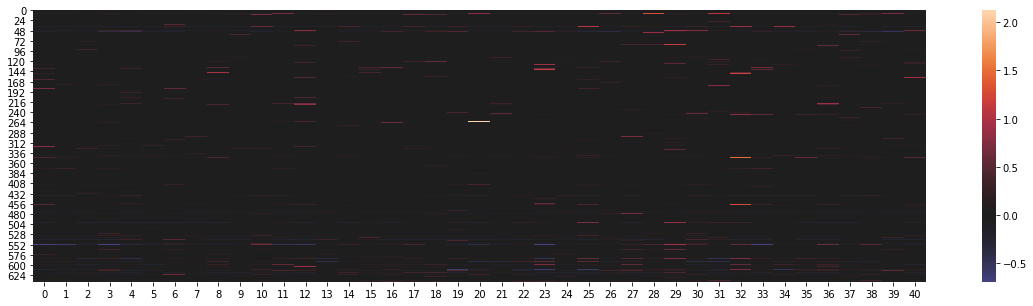

Round correlation 0.06738226505459884
#######################
FILTERING PERCENTILE: 50.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 7.182911574840546)
Coordinate:  example:727,start:317,end:358,rc:False
Contrib scores:


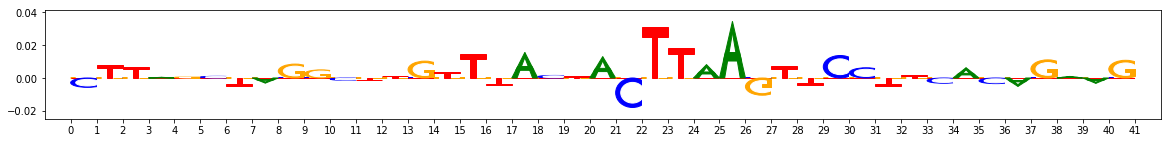

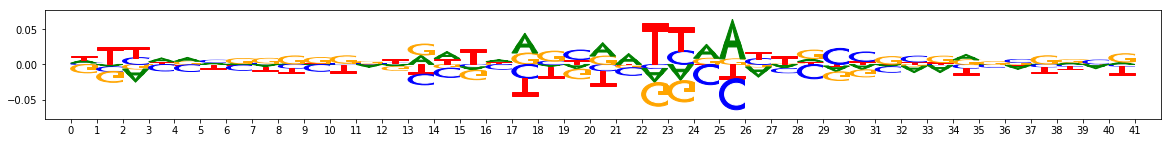

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 7.182911574840546


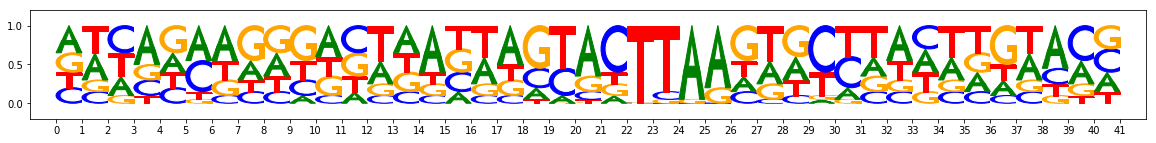

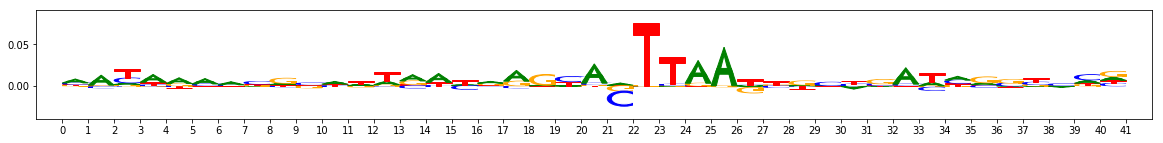

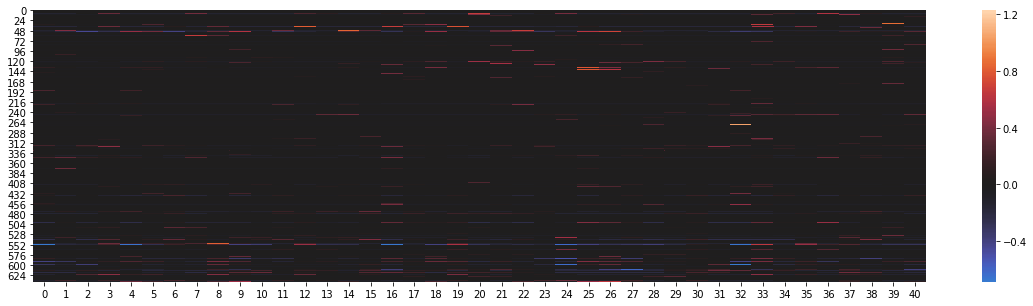

Round correlation 0.05223169721668293
#######################
FILTERING PERCENTILE: 55.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 7.519390940666199)
Coordinate:  example:451,start:398,end:439,rc:False
Contrib scores:


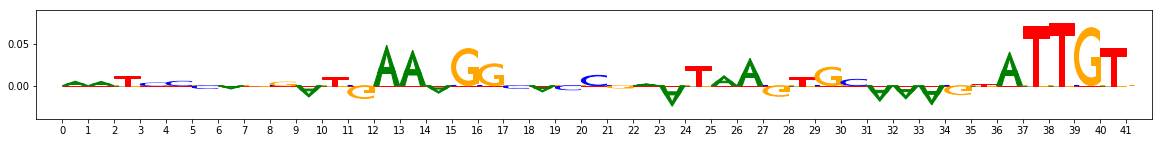

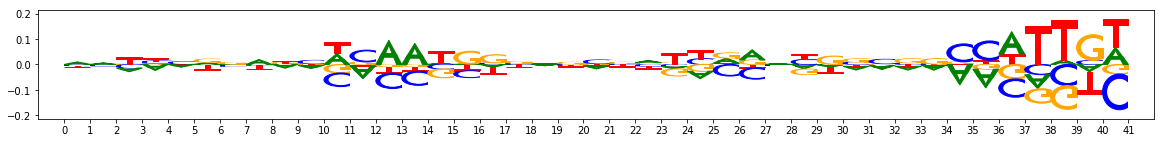

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 7.519390940666199


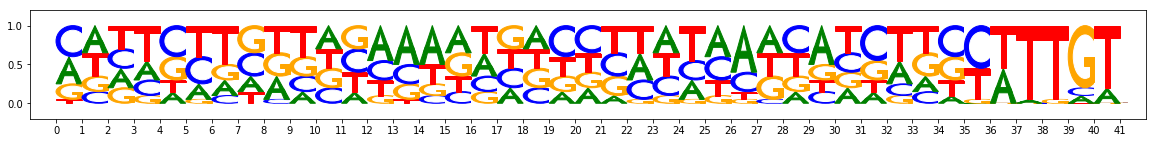

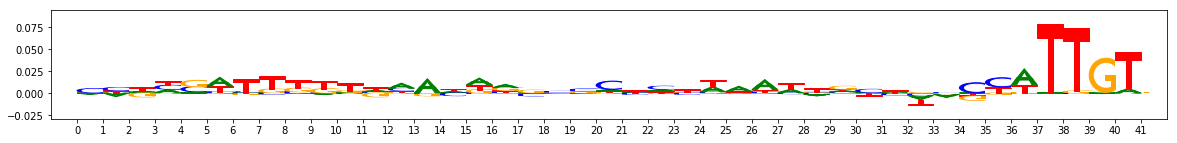

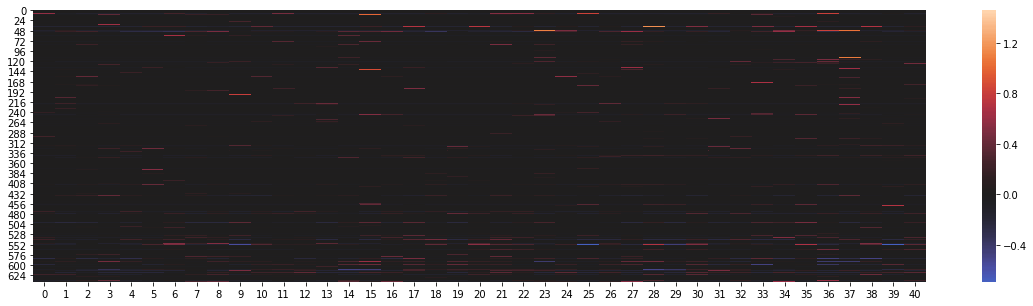

Round correlation -0.008594318776635647
#######################
FILTERING PERCENTILE: 60.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 7.875555753707886)
Coordinate:  example:657,start:449,end:490,rc:False
Contrib scores:


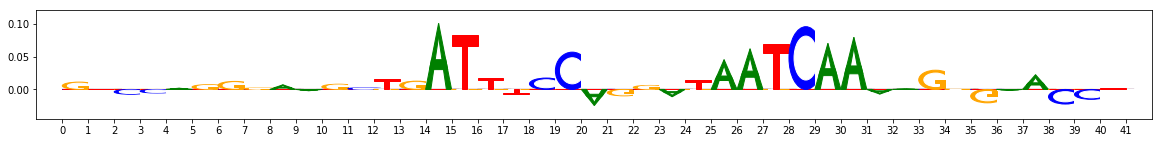

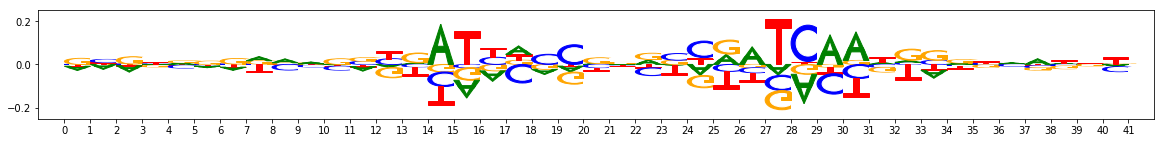

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 7.875555753707886


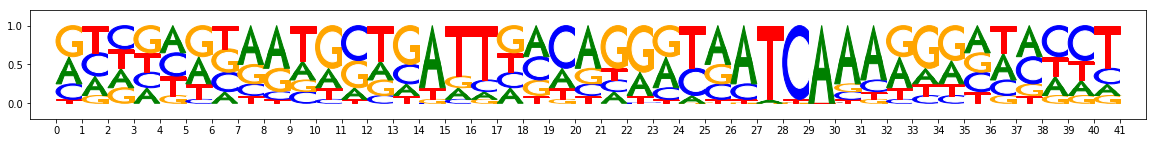

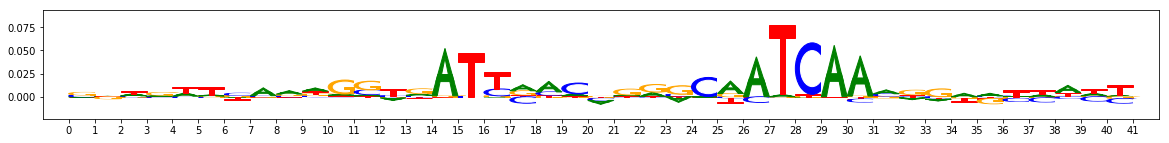

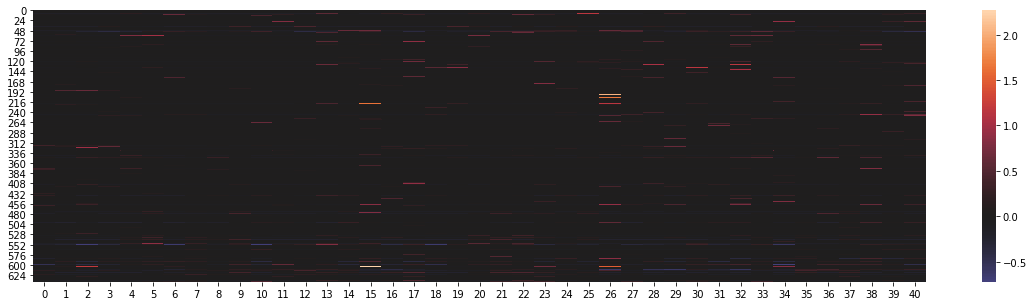

Round correlation 0.11615297450451977
#######################
FILTERING PERCENTILE: 65.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 8.237890273332596)
Coordinate:  example:789,start:440,end:481,rc:False
Contrib scores:


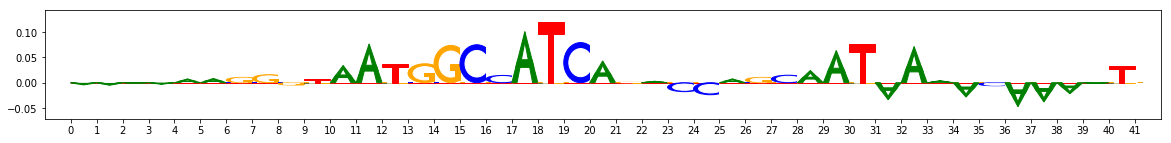

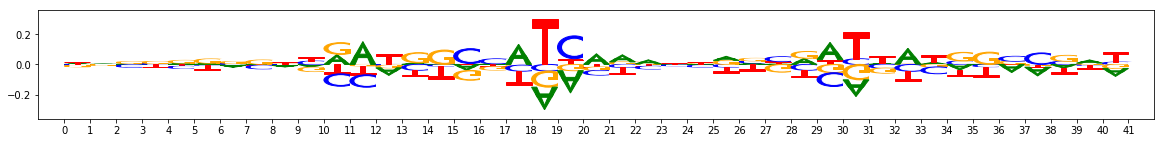

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 8.237890273332596


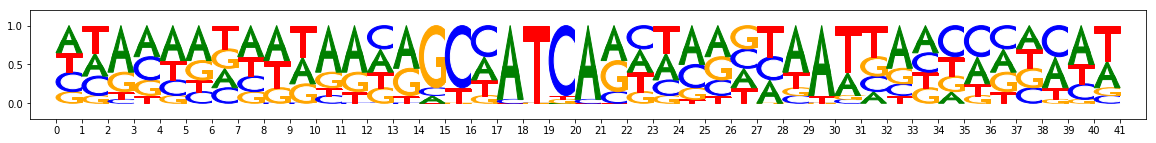

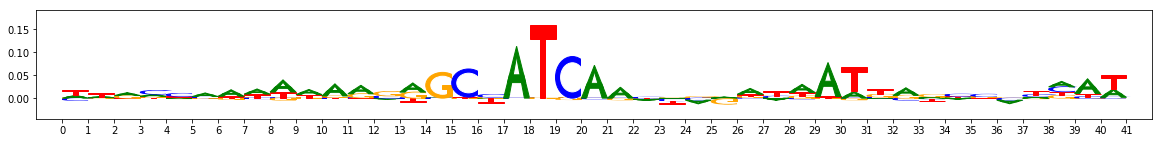

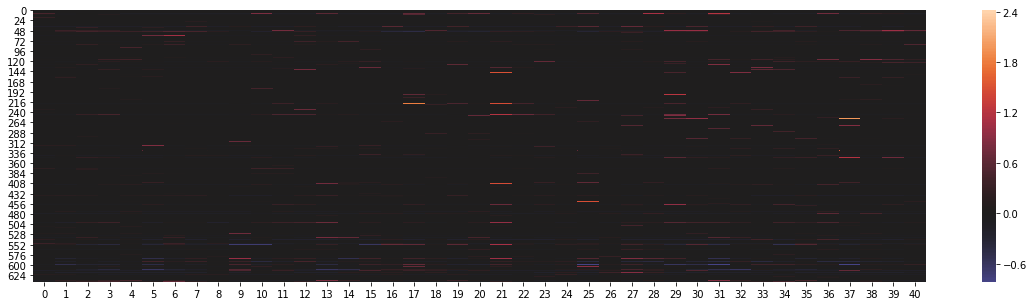

Round correlation 0.11538335281627982
#######################
FILTERING PERCENTILE: 70.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 8.577375769615173)
Coordinate:  example:946,start:476,end:517,rc:False
Contrib scores:


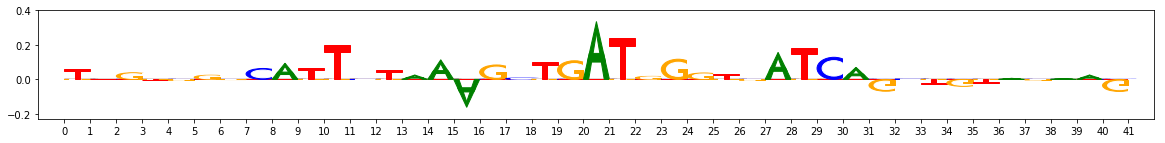

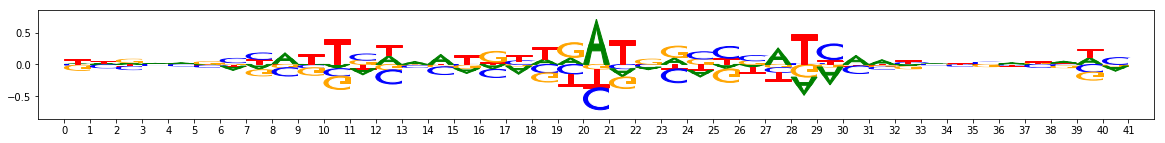

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 8.577375769615173


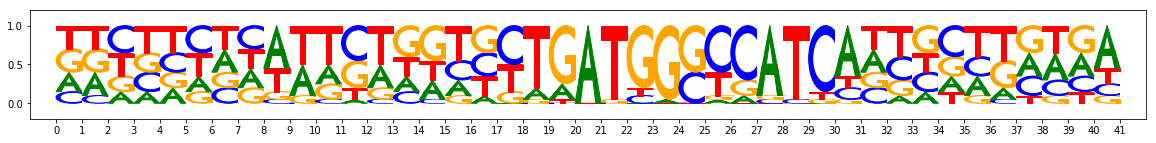

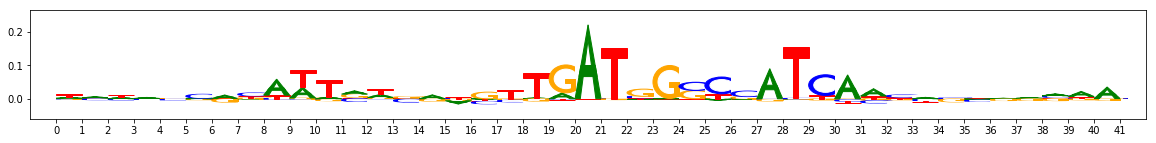

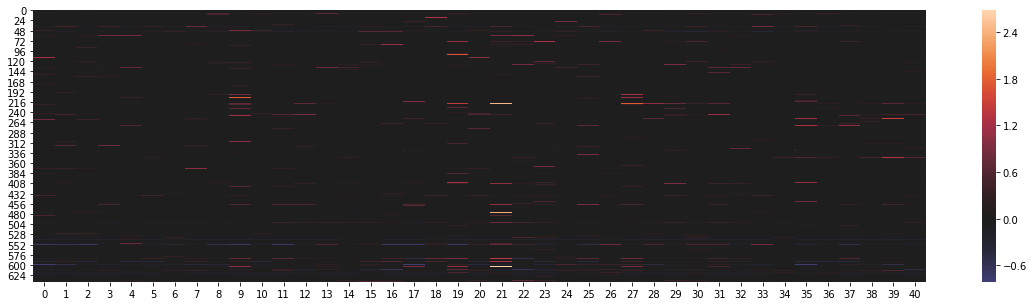

Round correlation 0.19441988665314272
#######################
FILTERING PERCENTILE: 75.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 8.907691717147827)
Coordinate:  example:846,start:526,end:567,rc:False
Contrib scores:


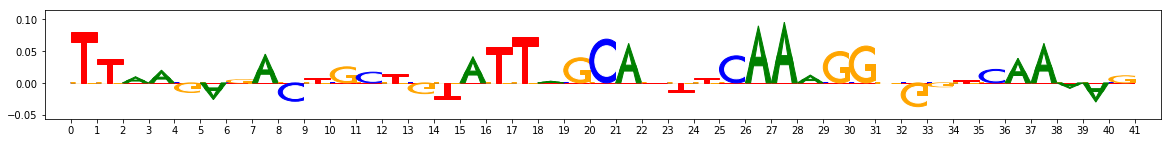

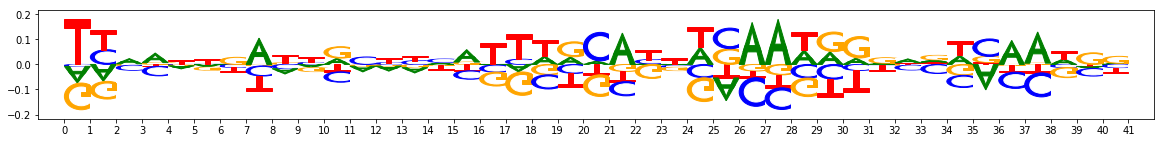

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 8.907691717147827


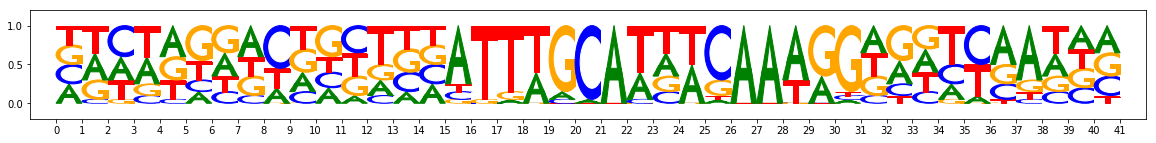

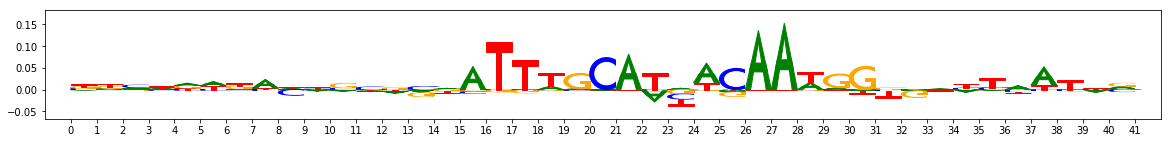

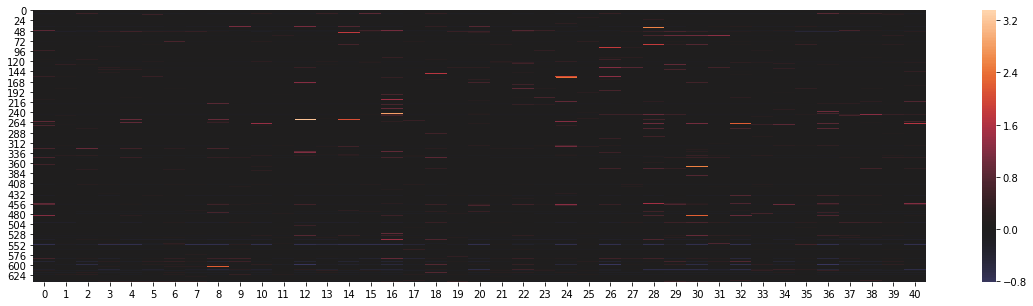

Round correlation 0.33079854584986085
#######################
FILTERING PERCENTILE: 80.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 9.261887609958649)
Coordinate:  example:919,start:396,end:437,rc:False
Contrib scores:


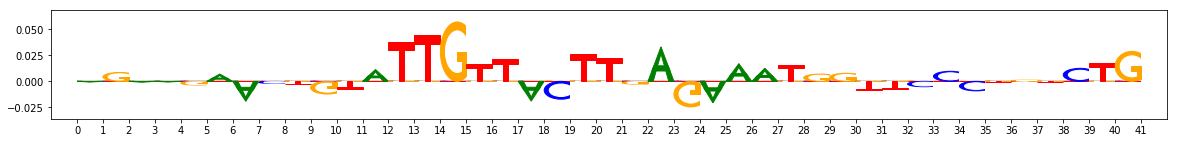

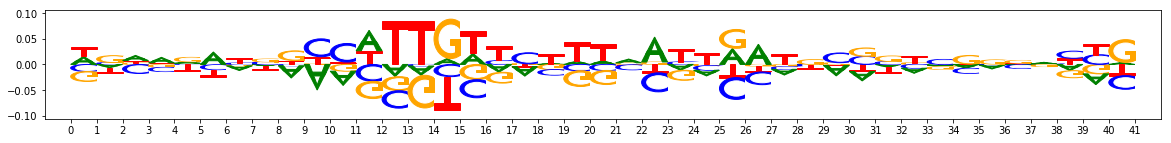

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 9.261887609958649


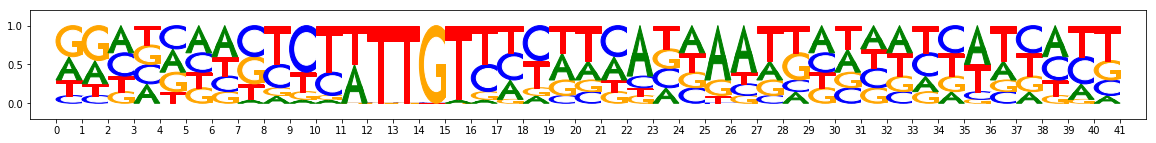

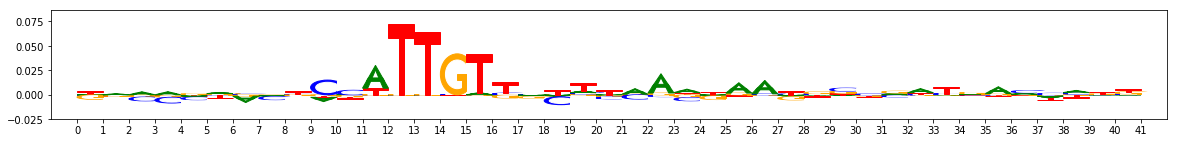

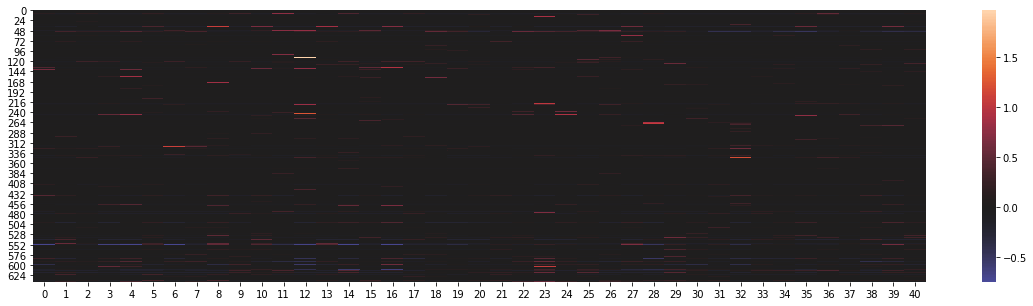

Round correlation 0.12359277255494315
#######################
FILTERING PERCENTILE: 85.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 9.63347601890564)
Coordinate:  example:481,start:378,end:419,rc:False
Contrib scores:


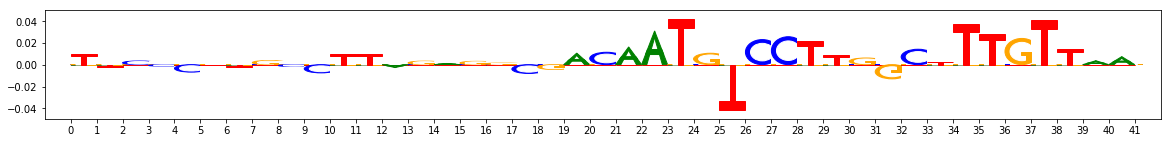

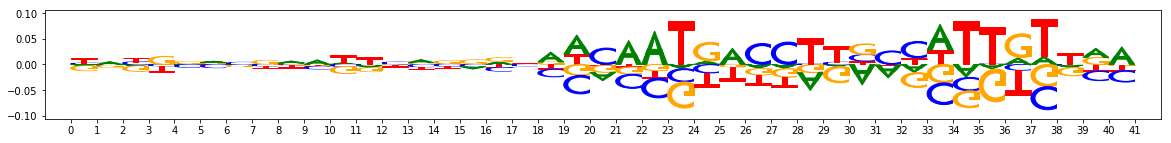

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 9.63347601890564


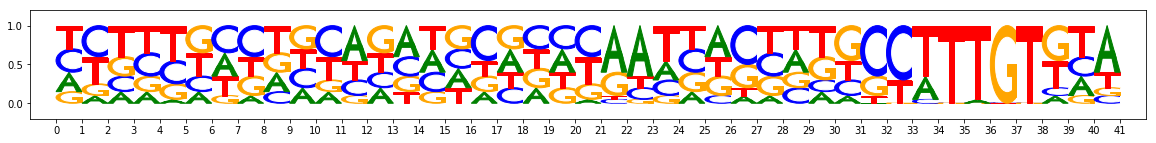

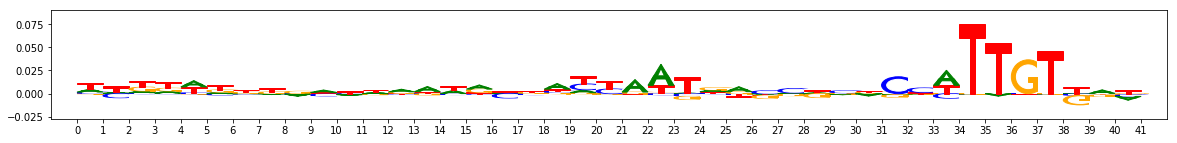

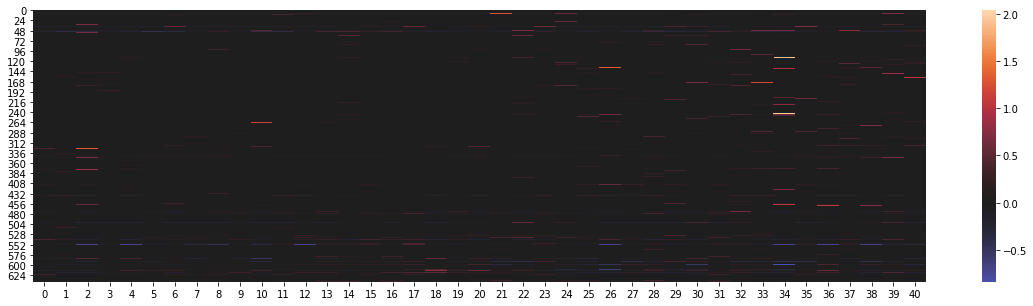

Round correlation 0.0851728456317412
#######################
FILTERING PERCENTILE: 90.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 9.975736618041992)
Coordinate:  example:978,start:579,end:620,rc:False
Contrib scores:


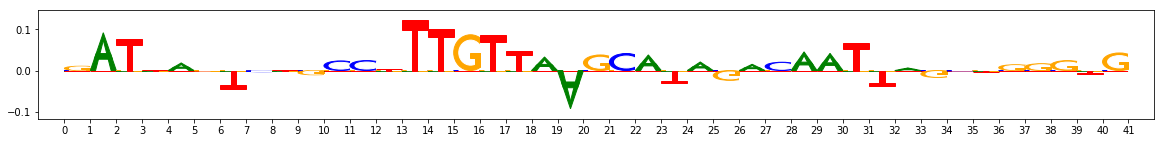

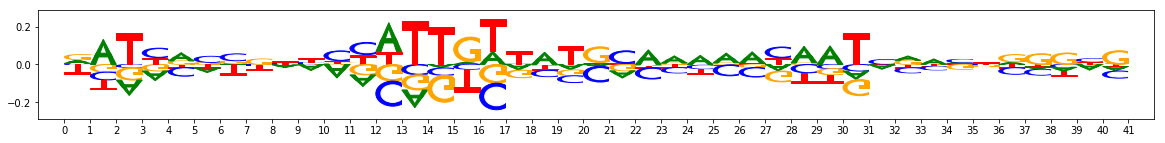

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 9.975736618041992


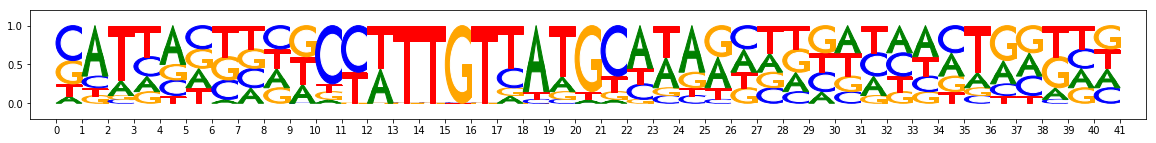

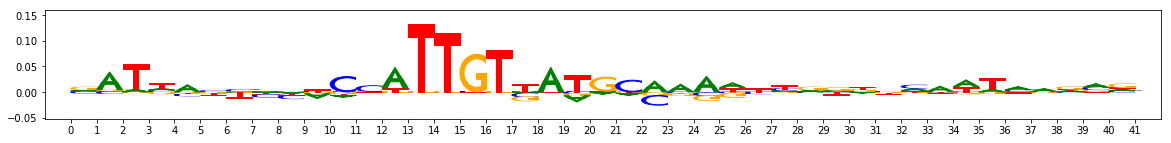

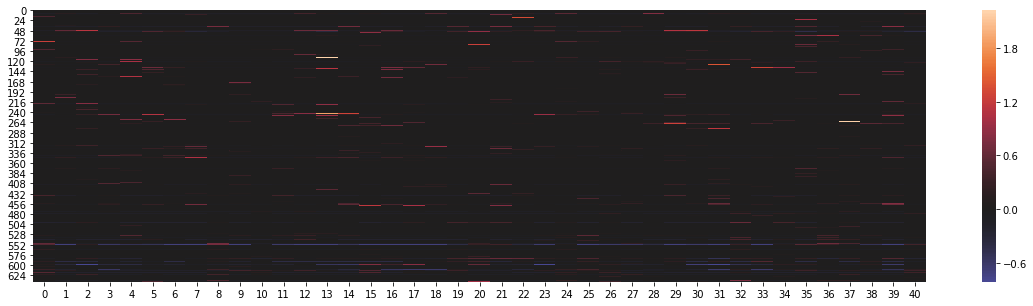

Round correlation 0.2707239455195694
#######################
FILTERING PERCENTILE: 95.0
#######################
-----------
Filtered seqlet @ percentile, sorted via Last round Information Content of 20 NN PFM (value: 10.395550608634949)
Coordinate:  example:14,start:484,end:525,rc:False
Contrib scores:


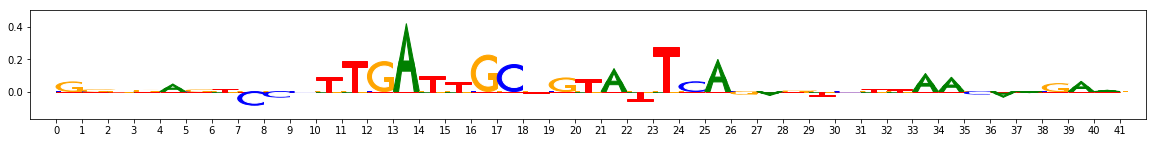

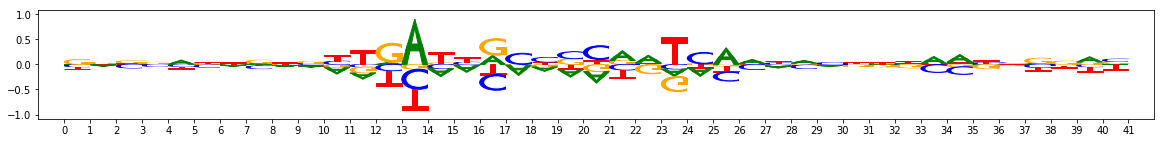

Round 0  PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC 10.395550608634949


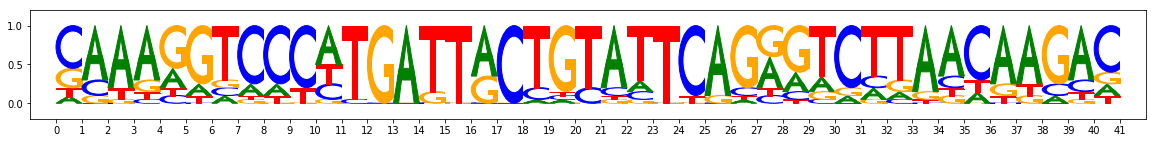

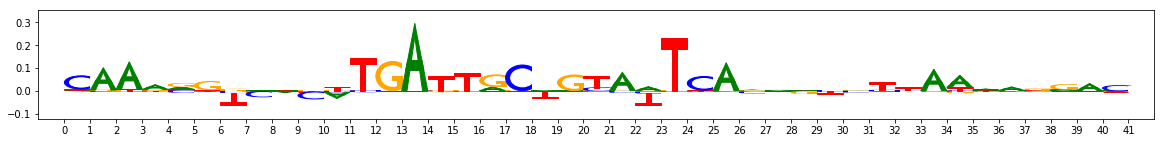

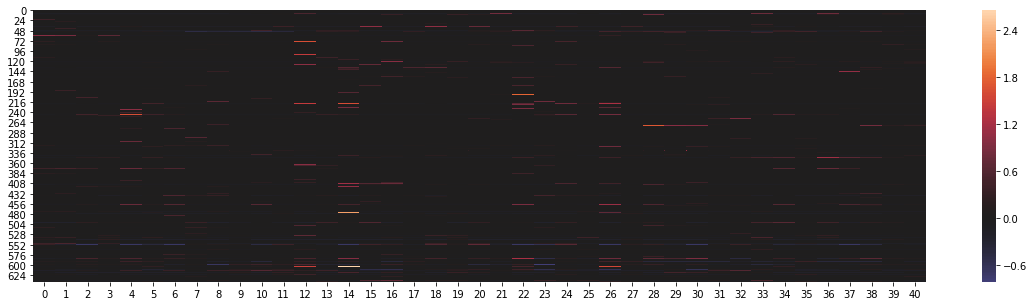

Round correlation 0.2712401238456981


In [58]:
import seaborn as sns
ics_argsort = np.argsort(round_premotif_ics[-1])

def perpos_meannorm(arr):
    return arr - np.mean(arr, axis=-1)[:,None]

from modisco.visualization import viz_sequence
steps=20 #steps to visualize
for i in range(20):
    print("#######################\nFILTERING PERCENTILE:",100*i/steps)
    print("#######################")
    argsort_idx_lookup = i*int(len(seqlets)/steps)
    ics_idx = ics_argsort[argsort_idx_lookup]
    for seqlet_idx, rankingvals, idxtypename in [
        (ics_idx, round_premotif_ics[-1], "Last round Information Content of "+str(NUM_IN_PREMOTIF)+" NN PFM")]:
        print("-----------\nFiltered seqlet @ percentile, sorted via "+idxtypename+" (value: "+str(rankingvals[seqlet_idx])+")")
        print("Coordinate: ",seqlets[seqlet_idx].coor)
        print("Contrib scores:")
        viz_sequence.plot_weights(seqlets[seqlet_idx]["Nanog_profile_wn_contrib_scores"].fwd)
        viz_sequence.plot_weights(perpos_meannorm(seqlets[seqlet_idx]["Nanog_profile_wn_hypothetical_contribs"].fwd))
        for roundidx in range(len(round_premotif_ics)):
            print("Round",roundidx," PFM from 50 nearest seqlets (prefilt using conv embedding coarse-grained); IC "
                  +str(round_premotif_ics[roundidx][seqlet_idx]))
            viz_sequence.plot_weights(round_premotif_avgseqlets[roundidx][seqlet_idx]["sequence"].fwd)
            viz_sequence.plot_weights(round_premotif_avgseqlets[roundidx][seqlet_idx]["Nanog_profile_wn_contrib_scores"].fwd)
            plt.figure(figsize=(20,5))
            sns.heatmap(fullconv_normed_embedding_fwd[seqlet_idx].transpose(), center=0)
            plt.show()
            #viz_sequence.plot_weights(round_premotif_avgseqlets[roundidx][seqlet_idx]["Nanog_profile_wn_hypothetical_contribs"].fwd)
            print("Round correlation", round_correlations[roundidx][seqlet_idx])
    
#for i in premotif_ics_argsort[::int(len(seqlets)/50)]:
#    print(premotif_ics_argsort[i],
#          premotif_ics[premotif_ics_argsort[i]])
#    viz_sequence.plot_weights(
#        seqlets[premotif_ics_argsort[i]]
#               ["Nanog_profile_wn_contrib_scores"].fwd)